## Import

In [1]:
import mne
import numpy as np
import scipy
import os
from scipy import signal as sg
from matplotlib import pyplot as plt
from mne.preprocessing import ICA, corrmap, create_ecg_epochs, create_eog_epochs

## Load Data

In [9]:
directory_path = "D:/EEG RESEARCH DATA"
os.chdir(directory_path)

raw = mne.io.read_raw_brainvision("20240129_mat5mins/20240129_mat5mins_001.vhdr")

# Reconstruct the original events from our Raw object
events, event_ids = mne.events_from_annotations(raw)

Extracting parameters from 20240129_mat5mins/20240129_mat5mins_001.vhdr...
Setting channel info structure...
Used Annotations descriptions: ['New Segment/', 'Stimulus/S  1']


In [3]:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_channel_types({'ECG':'ecg'})
raw.set_channel_types({'vEOG':'eog'})
raw.set_channel_types({'hEOG':'eog'})

<RawBrainVision | 20240129_mat5mins_001.eeg, 67 x 939200 (939.2 s), ~72 kB, data not loaded>

In [4]:
raw.set_montage(montage)
#fig = raw.plot_sensors(show_names=True)

<RawBrainVision | 20240129_mat5mins_001.eeg, 67 x 939200 (939.2 s), ~98 kB, data not loaded>

## ECG Analysis

### Using My Pan Tompkins Algorithm

In [5]:
##Testing only on ECG, T = 60 secs
#raw_ecg = raw.copy().pick_types(eeg=False, eog=False, ecg=True).crop(tmin = 60, tmax = 120) #make a copy


#Testing only on ECG, T = Whole experiment actual time
raw_ecg = raw.copy().pick_types(eeg=False, eog=False, ecg=True).crop(tmin = 17.101, tmax = 918.461) #make a copy

In [6]:
fs = 1000
mne_ecg, mne_time = raw_ecg[:]
mne_ecg = -mne_ecg.T

####  Pan Tompkins Alogrithm

In [7]:
class pan_tompkins_qrs():
    def bpf(self,x):
        
        
        
        y_filtered = None

        #Results will be delayed 16 Samples
        y = x.copy()

        #Low Pass Filter
        #y(n) = 2y(n-1) - y(n-2) + x(n) - 2x(n-6) + x(n-12)
        for n in range(len(x)):
            y[n] = x[n]

            if (n >= 1):
                y[n] += 2*y[n-1]
            if (n >= 2):
                y[n] -= y[n-2]
            if (n >= 6):
                y[n] -= 2*x[n-6]
            if (n >= 12):
                y[n] += x[n-12]
        
        y_filtered = y.copy()

        #High Pass Filter
        #y(n) = 32x(n-16) - y(n-1) - x(n) + x(n-32)
        for n in range(len(x)):
            y_filtered[n] = -1*y[n]

            if (n >= 1):
                y_filtered[n] -= y_filtered[n-1]
            if (n >= 16):
                y_filtered[n] += 32*y[n-16]
            if(n >= 32):
                y_filtered[n] += y[n-32]
        
        #Normalization
        max_val = max(max(y_filtered), -min(y_filtered))
        y_filtered = y_filtered/max_val

        return y_filtered
    
    def derivative(self,x,fs):
        
        #Results will be delayed for 2 samples
        y_derived = x.copy()
        
        #Derivative Filter
        #y(n) = [-x(n-2) - 2x(n-1) + 2x(n+1) + x(n+2)]/8
        for n in range(len(x)):
            y_derived[n] = 0

            if (n >= 1):
                y_derived[n] -= 2*x[n-1]
            if (n >= 2):
                y_derived[n] -= x[n-2]
            
            ###Not sure what this part is for###
            if (n >= 2 and n <= len(x)-2):
                y_derived[n] += 2*x[n+1]
            if (n >= 2 and n<= len(x)-3):
                y_derived[n] += x[n+2]
            ###Not sure what this part is for###

            ###Not sure why does it has to be times to "fs"###
            y_derived[n] = (y_derived[n]*fs)/8
            ###Not sure why does it has to be times to "fs"###
        
        return y_derived
    
    def squaring(self,x):
        
        y_squared = x.copy()

        for n in range(len(x)):
            y_squared[n] = x[n]**2

        return y_squared
    
    def moving_window_integration(self,x,fs):
        # Initialize result and window size for integration
        y = x.copy()
        win_size = round(0.150 * fs)
        sum = 0

        # Calculate the sum for the first N terms
        for j in range(win_size):
            sum += x[j]/win_size
            y[j] = sum
        
        # Apply the moving window integration using the equation given
        for n in range(win_size,len(x)):  
            sum += x[n]/win_size
            sum -= x[n-win_size]/win_size
            y[n] = sum

        return y

    def solve(self,x,fs):

        # Convert the input signal into numpy array
        input_signal = x.copy()

        # Bandpass Filter
        global bpass
        bpass = self.bpf(input_signal.copy())

        # Derivative Function
        global der
        der = self.derivative(bpass.copy(),fs)

        # Squaring Function
        global sqr
        sqr = self.squaring(der.copy())

        # Moving Window Integration Function
        global mwin
        mwin = self.moving_window_integration(sqr.copy(),fs)

        return mwin


In [8]:
class heart_rate():
    def __init__(self,x,fs):
        #Initialize Variables
        self.RR1, self.RR2, self.probable_peaks, self.r_locs, self.peaks, self.result = ([] for i in range(6))
        self.SPKI, self.NPKI, self.Threshold_I1, self.Threshold_I2, self.SPKF, self.NPKF, self.Threshold_F1, self.Threshold_F2 = (0 for i in range(8))

        self.T_wave = False
        self.m_win = mwin
        self.b_pass = bpass
        self.fs = fs
        self.signal = x
        self.win_150ms = round(0.15*self.fs)

        self.RR_Low_Limit = 0
        self.RR_High_Limit = 0
        self.RR_Missed_Limit = 0
        self.RR_Average1 = 0

    def approx_peak(self):
        ###Change from the original code by making the size to (A x 1) instead of (A x )###
        slopes = sg.fftconvolve(self.m_win, np.full((25,1),1)/25, mode='same')
        ###Change from the original code by making the size to (A x 1) instead of (A x )###

        # for i in range(round(0.5*self.fs) + 1,len(slopes)-1):
        for i in range(0,len(slopes)-1):
            if (slopes[i] > slopes[i-1]) and (slopes[i+1] <slopes[i]):
                self.peaks.append(i)

    def adjust_rr_interval(self, ind):
        self.RR1 = np.diff(self.peaks[max(0,ind - 8) : ind + 1])/self.fs  

        # Calculating RR Averages
        self.RR_Average1 = np.mean(self.RR1)
        RR_Average2 = self.RR_Average1
        
        # Finding the eight most recent RR intervals lying between RR Low Limit and RR High Limit  
        if (ind >= 8):
            for i in range(0, 8):
                if (self.RR_Low_Limit < self.RR1[i] < self.RR_High_Limit): 
                    self.RR2.append(self.RR1[i])

                    if (len(self.RR2) > 8):
                        self.RR2.remove(self.RR2[0])
                        RR_Average2 = np.mean(self.RR2)    

        # Adjusting the RR Low Limit and RR High Limit
        if (len(self.RR2) > 7 or ind < 8):
            self.RR_Low_Limit = 0.92 * RR_Average2        
            self.RR_High_Limit = 1.16 * RR_Average2
            self.RR_Missed_Limit = 1.66 * RR_Average2
    
    def searchback(self, peak_val, RRn, sb_win):
        # Check if the most recent RR interval is greater than the RR Missed Limit
        if (RRn > self.RR_Missed_Limit):
            # Initialize a window to searchback  
            win_rr = self.m_win[peak_val - sb_win + 1 : peak_val + 1] 

            # Find the x locations inside the window having y values greater than Threshold I1             
            coord = np.asarray(win_rr > self.Threshold_I1).nonzero()[0]

            # Find the x location of the max peak value in the search window
            if (len(coord) > 0):
                for pos in coord:
                    if (win_rr[pos] == max(win_rr[coord])):
                        x_max = pos
                        break
            else:
                x_max = None
    
            # If the max peak value is found
            if (x_max is not None):   
                # Update the thresholds corresponding to moving window integration
                self.SPKI = 0.25 * self.m_win[x_max] + 0.75 * self.SPKI                         
                self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
                self.Threshold_I2 = 0.5 * self.Threshold_I1         

                # Initialize a window to searchback 
                win_rr = self.b_pass[x_max - self.win_150ms: min(len(self.b_pass) -1, x_max)]  

                # Find the x locations inside the window having y values greater than Threshold F1                   
                coord = np.asarray(win_rr > self.Threshold_F1).nonzero()[0]

                # Find the x location of the max peak value in the search window
                if (len(coord) > 0):
                    for pos in coord:
                        if (win_rr[pos] == max(win_rr[coord])):
                            r_max = pos
                            break
                else:
                    r_max = None

                # If the max peak value is found
                if (r_max is not None):
                # Update the thresholds corresponding to bandpass filter
                    if self.b_pass[r_max] > self.Threshold_F2:                                                        
                        self.SPKF = 0.25 * self.b_pass[r_max] + 0.75 * self.SPKF                            
                        self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
                        self.Threshold_F2 = 0.5 * self.Threshold_F1      

                        # Append the probable R peak location                      
                        self.r_locs.append(r_max)

    def find_t_wave(self,peak_val,RRn,ind,prev_ind):
        '''
        T Wave Identification
        :param peak_val: peak location in consideration
        :param RRn: the most recent RR interval
        :param ind: current index in peaks array
        :param prev_ind: previous index in peaks array
        '''

        if (self.m_win[peak_val] >= self.Threshold_I1): 
            if (ind > 0 and 0.20 < RRn < 0.36):
                # Find the slope of current and last waveform detected        
                curr_slope = max(np.diff(self.m_win[peak_val - round(self.win_150ms/2) : peak_val + 1]))
                last_slope = max(np.diff(self.m_win[self.peaks[prev_ind] - round(self.win_150ms/2) : self.peaks[prev_ind] + 1]))
            
                # If current waveform slope is less than half of last waveform slope
                if (curr_slope < 0.5*last_slope):  
                    # T Wave is found and update noise threshold                      
                    self.T_wave = True                             
                    self.NPKI = 0.125 * self.m_win[peak_val] + 0.875 * self.NPKI 

            if (not self.T_wave):
                # T Wave is not found and update signal thresholds
                if (self.probable_peaks[ind] > self.Threshold_F1):   
                    self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI                                         
                    self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

                    # Append the probable R peak location
                    self.r_locs.append(self.probable_peaks[ind])  

                else:
                    self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI
                    self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                   

        # Update noise thresholds
        elif (self.m_win[peak_val] < self.Threshold_I1) or (self.Threshold_I1 < self.m_win[peak_val] < self.Threshold_I2):
            self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
            self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


    def adjust_thresholds(self,peak_val,ind):
        '''
        Adjust Noise and Signal Thresholds During Learning Phase
        :param peak_val: peak location in consideration
        :param ind: current index in peaks array
        '''

        if (self.m_win[peak_val] >= self.Threshold_I1): 
            # Update signal threshold
            self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI

            if (self.probable_peaks[ind] > self.Threshold_F1):                                            
                self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

                # Append the probable R peak location
                self.r_locs.append(self.probable_peaks[ind])  

            else:
                # Update noise threshold
                self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                                    
            
        # Update noise thresholds    
        elif (self.m_win[peak_val] < self.Threshold_I2) or (self.Threshold_I2 < self.m_win[peak_val] < self.Threshold_I1):
            self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
            self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


    def update_thresholds(self):
        '''
        Update Noise and Signal Thresholds for next iteration
        '''

        self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
        self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
        self.Threshold_I2 = 0.5 * self.Threshold_I1 
        self.Threshold_F2 = 0.5 * self.Threshold_F1
        self.T_wave = False 


    def ecg_searchback(self):
        '''
        Searchback in ECG signal to increase efficiency
        '''

        # Filter the unique R peak locations
        self.r_locs = np.unique(np.array(self.r_locs).astype(int))

        # Initialize a window to searchback
        win_200ms = round(0.2*self.fs)
    
        for r_val in self.r_locs:
            coord = np.arange(r_val - win_200ms, min(len(self.signal), r_val + win_200ms + 1), 1)

            # Find the x location of the max peak value
            if (len(coord) > 0):
                for pos in coord:
                    if (self.signal[pos] == max(self.signal[coord])):
                        x_max = pos
                        break
            else:
                x_max = None

            # Append the peak location
            if (x_max is not None):   
                self.result.append(x_max)


    def find_r_peaks(self):
        '''
        R Peak Detection
        '''

        # Find approximate peak locations
        self.approx_peak()

        # Iterate over possible peak locations
        for ind in range(len(self.peaks)):

            # Initialize the search window for peak detection
            peak_val = self.peaks[ind]
            win_300ms = np.arange(max(0, self.peaks[ind] - self.win_150ms), min(self.peaks[ind] + self.win_150ms, len(self.b_pass)-1), 1)
            max_val = max(self.b_pass[win_300ms], default = 0)

            # Find the x location of the max peak value
            if (max_val != 0):        
                x_coord = np.asarray(self.b_pass == max_val).nonzero()
                self.probable_peaks.append(x_coord[0][0])
                
            if (ind < len(self.probable_peaks) and ind != 0):
                # Adjust RR interval and limits
                self.adjust_rr_interval(ind)
                
                # Adjust thresholds in case of irregular beats
                if (self.RR_Average1 < self.RR_Low_Limit or self.RR_Average1 > self.RR_Missed_Limit): 
                    self.Threshold_I1 /= 2
                    self.Threshold_F1 /= 2

                RRn = self.RR1[-1]

                # Searchback
                self.searchback(peak_val,RRn,round(RRn*self.fs))

                # T Wave Identification
                self.find_t_wave(peak_val,RRn,ind,ind-1)

            else:
                # Adjust threholds
                self.adjust_thresholds(peak_val,ind)

            # Update threholds for next iteration
            self.update_thresholds()

        # Searchback in ECG signal 
        self.ecg_searchback()

        return self.result


#### Utilization of the Pan Tompkins Algorithm

In [10]:
QRS_detector = pan_tompkins_qrs()
output = QRS_detector.solve(mne_ecg, fs)

In [11]:
# Convert ecg signal to numpy array
signal = mne_ecg.copy()

# Find the R peak locations
hr = heart_rate(signal,fs)
result = hr.find_r_peaks()
result = np.array(result)

# Clip the x locations less than 0 (Learning Phase)
result = result[result > 0]

C:\Users\Jeremi\AppData\Local\Temp\ipykernel_15076\2487238089.py:115: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  curr_slope = max(np.diff(self.m_win[peak_val - round(self.win_150ms/2) : peak_val + 1]))
C:\Users\Jeremi\AppData\Local\Temp\ipykernel_15076\2487238089.py:116: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  last_slope = max(np.diff(self.m_win[self.peaks[prev_ind] - round(self.win_150ms/2) : self.peaks[prev_ind] + 1]))
C:\Users\Jeremi\AppData\Local\Temp\ipykernel_15076\2487238089.py:119: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if (curr_slope < 0.5*

In [12]:
###Pre Process, Data Cleaning ECG###
r_peak = np.unique(result)

a = []
a += [value for value in r_peak if 478500 <= value <= 479500 or 732000 <= value <= 734000]
new_r_peak = [value for value in r_peak if value not in a]
new_r_peak = np.array(new_r_peak)

start_index = np.argmax(new_r_peak >= 731500)

new_values = [732495, 733050, 733600]

new_r_peak = np.insert(new_r_peak, [start_index+1,start_index+2,start_index+3], new_values)
r_peak = new_r_peak.copy()

result = r_peak.copy()

del(a, start_index, new_values, new_r_peak)
###Pre Process, Data Cleaning ECG###

Heart Rate 65.67896070609332 BPM


Text(0.5, 1.0, 'R Peak Locations')

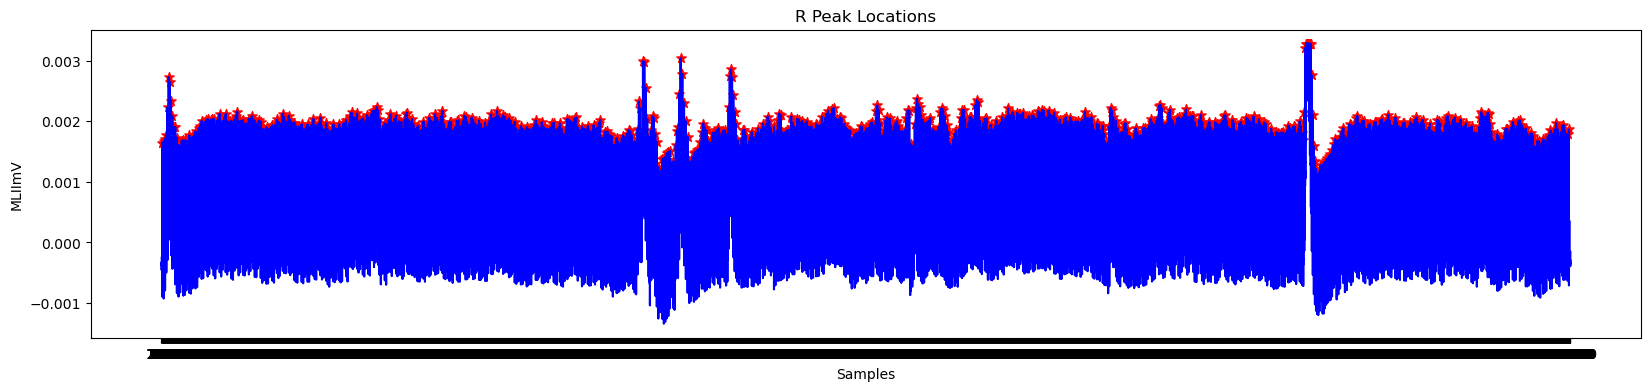

In [13]:
# Calculate the heart rate
heartRate = (60*fs)/np.average(np.diff(result[1:]))
print("Heart Rate",heartRate, "BPM")

# Plotting the R peak locations in ECG signal
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(signal)+1, 150))
plt.plot(signal, color = 'blue')        
plt.scatter(result, signal[result], color = 'red', s = 50, marker= '*')
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("R Peak Locations")

In [ ]:
len(r_peak)

986

In [ ]:
#Find R-Peak and RRI
rri = np.sort(r_peak).copy()
rri[1:] = rri[1:] - rri[:-1]

In [ ]:
len(rri)

986

#### Data Interpolation and STFT

In [9]:
#Data Interpolation, Fs = 1000
exp_duration = len(mne_ecg)/fs

x_vals = np.linspace(0,r_peak[-1],int(exp_duration*fs))
splines = scipy.interpolate.splrep(r_peak,rri)
y_vals = scipy.interpolate.splev(x_vals,splines)

plt.figure(figsize = (20,4),dpi = 100)
plt.plot(x_vals/1000,y_vals)
plt.axvline(x = 300, color = 'r')
plt.axvline(x = 600, color = 'r')

plt.title('Interpolated RRI')
plt.ylabel('RRI [ms]')
plt.xlabel('Time [sec]')


NameError: name 'r_peak' is not defined

#### Frequency Analysis

In [ ]:
y_firstrest = y_vals[:300000]
y_stress = y_vals[300001:600000]
y_secondrest = y_vals[600001:]

##### PSD Measurement using Welch Method

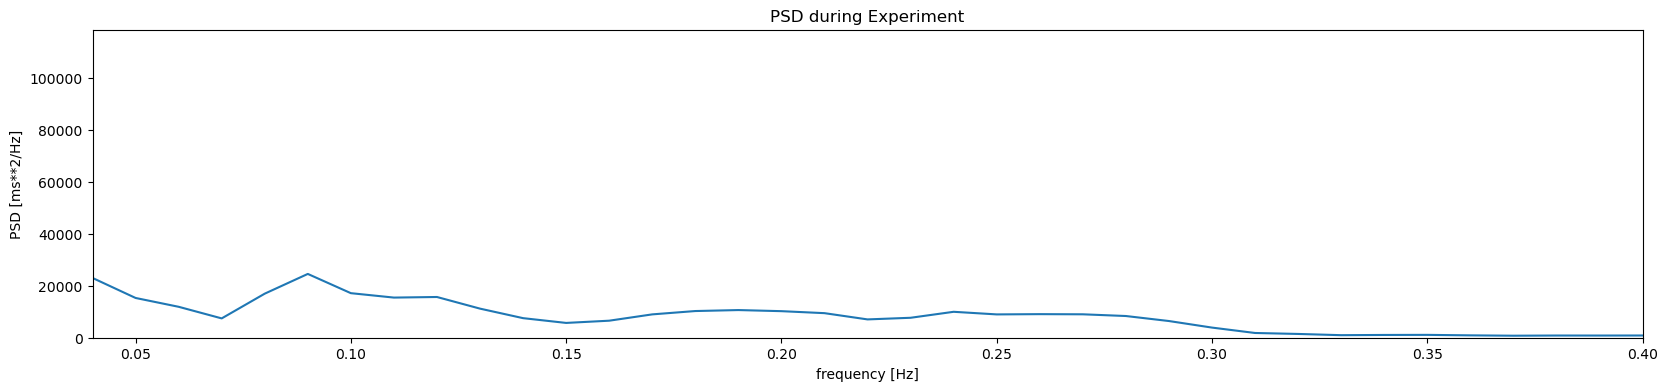

Absolute Power LF =  171929.0606168525 ms**2/Hz
Absolute Power HF =  142981.25957147026 ms**2/Hz
Total Power =  571208.0661930703 ms**2/Hz
LF/HF Ratio =  1.2024587077505249
Normalized Power LF =  30.09920041268113 %
Normalized Power HF =  25.031379637965777 %
Normalized LF/HF Ratio =  1.2024587077505249 %


In [ ]:
nperseg = 100000
noverlap = nperseg*2/3

f_den, Pxx_den = sg.welch(y_vals,fs,nperseg = nperseg, noverlap=noverlap)

idx_lf = np.where((0.04 <= f_den) & (f_den <= 0.15))
idx_hf = np.where((0.15 <= f_den) & (f_den <= 0.40))
idx_lfhf = np.where((0.04 <= f_den) & (f_den <= 0.40))
idx_tot_power = np.where((0 <= f_den) & (f_den <= 0.40))

plt.figure(figsize = (20,4), dpi = 100)
plt.plot(f_den, Pxx_den)
plt.xlim(0.04, 0.4)
plt.ylim(bottom=0)
plt.title('PSD during Experiment')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [ms**2/Hz]')
plt.show()

abs_power_LF = np.sum(np.abs(Pxx_den[idx_lf]))
abs_power_HF = np.sum(np.abs(Pxx_den[idx_hf]))
tot_power = np.sum(np.abs(Pxx_den[idx_tot_power]))

print('Absolute Power LF = ', abs_power_LF, 'ms**2/Hz')
print('Absolute Power HF = ',  abs_power_HF, 'ms**2/Hz')
print('Total Power = ', tot_power, 'ms**2/Hz' )

lf_hf_ratio = abs_power_LF/abs_power_HF
print('LF/HF Ratio = ', lf_hf_ratio)

norm_power_LF = (abs_power_LF/tot_power)*100
norm_power_HF = (abs_power_HF/tot_power)*100
norm_lf_hf_ratio = norm_power_LF/norm_power_HF
print('Normalized Power LF = ', norm_power_LF, '%')
print('Normalized Power HF = ',  norm_power_HF, '%')
print('Normalized LF/HF Ratio = ', norm_lf_hf_ratio, '%')

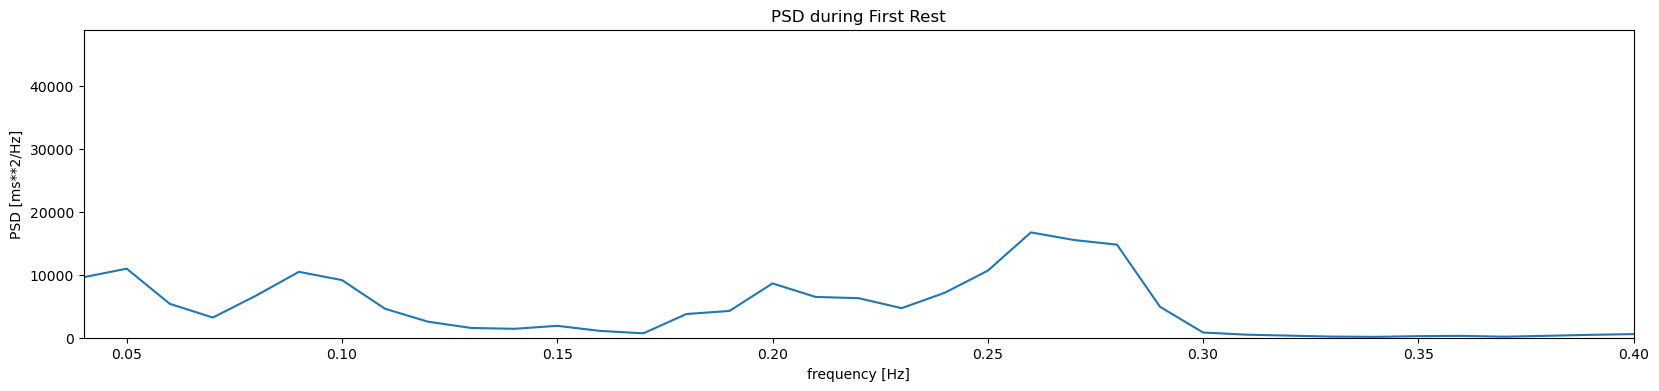

Absolute Power LF =  67409.46258862686 ms**2/Hz
Absolute Power HF =  111439.42691474668 ms**2/Hz
Total Power =  273620.2838881352 ms**2/Hz
LF/HF Ratio =  0.6048977857737585
Normalized Power LF =  24.63613502286476 %
Normalized Power HF =  40.72776525599495 %
Normalized LF/HF Ratio =  0.6048977857737585 %


In [ ]:
nperseg = 100000
noverlap = nperseg*2/3

f_den, Pxx_den = sg.welch(y_firstrest,fs,nperseg = nperseg, noverlap=noverlap)

idx_lf = np.where((0.04 <= f_den) & (f_den <= 0.15))
idx_hf = np.where((0.15 <= f_den) & (f_den <= 0.40))
idx_lfhf = np.where((0.04 <= f_den) & (f_den <= 0.40))
idx_tot_power = np.where((0 <= f_den) & (f_den <= 0.40))

plt.figure(figsize = (20,4), dpi = 100)
plt.plot(f_den, Pxx_den)
plt.xlim(0.04, 0.4)
plt.ylim(bottom=0)
plt.title('PSD during First Rest')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [ms**2/Hz]')
plt.show()

abs_power_LF = np.sum(np.abs(Pxx_den[idx_lf]))
abs_power_HF = np.sum(np.abs(Pxx_den[idx_hf]))
tot_power = np.sum(np.abs(Pxx_den[idx_tot_power]))

print('Absolute Power LF = ', abs_power_LF, 'ms**2/Hz')
print('Absolute Power HF = ',  abs_power_HF, 'ms**2/Hz')
print('Total Power = ', tot_power, 'ms**2/Hz' )

lf_hf_ratio = abs_power_LF/abs_power_HF
print('LF/HF Ratio = ', lf_hf_ratio)

norm_power_LF = (abs_power_LF/tot_power)*100
norm_power_HF = (abs_power_HF/tot_power)*100
norm_lf_hf_ratio = norm_power_LF/norm_power_HF
print('Normalized Power LF = ', norm_power_LF, '%')
print('Normalized Power HF = ',  norm_power_HF, '%')
print('Normalized LF/HF Ratio = ', norm_lf_hf_ratio, '%')

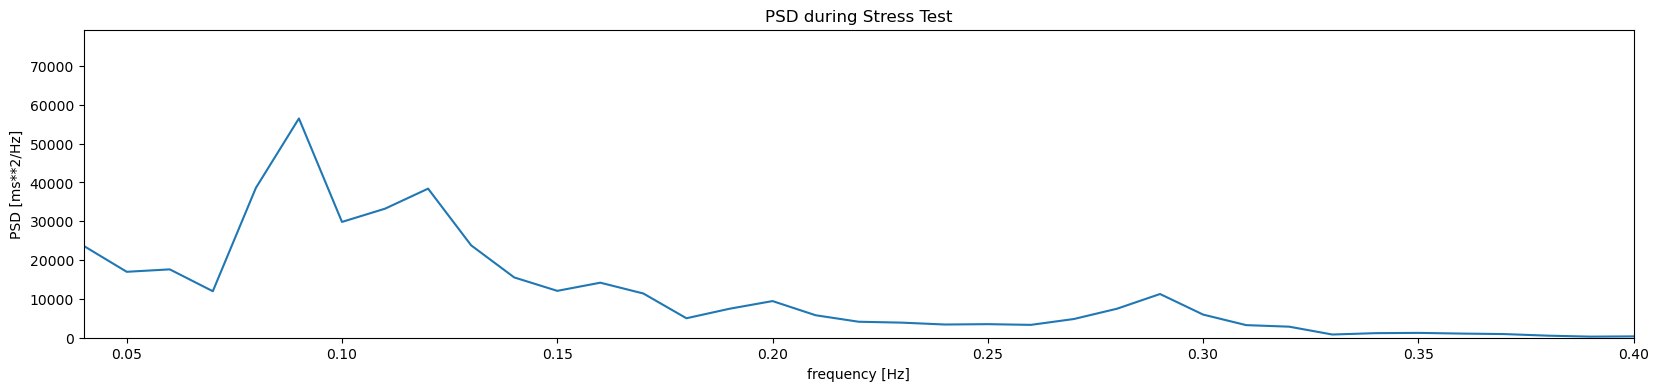

Absolute Power LF =  318176.058322899 ms**2/Hz
Absolute Power HF =  125573.89761284488 ms**2/Hz
Total Power =  633538.5204120771 ms**2/Hz
LF/HF Ratio =  2.5337754451475507
Normalized Power LF =  50.222054077460896 %
Normalized Power HF =  19.82103590657233 %
Normalized LF/HF Ratio =  2.5337754451475507 %


In [ ]:
nperseg = 100000
noverlap = nperseg*2/3

f_den, Pxx_den = sg.welch(y_stress,fs,nperseg = nperseg, noverlap=noverlap)
plt.figure(figsize = (20,4), dpi = 100)
plt.plot(f_den, Pxx_den)
plt.xlim(0.04, 0.4)
plt.ylim(bottom=0)
plt.title('PSD during Stress Test')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [ms**2/Hz]')
plt.show()

idx_lf = np.where((0.04 <= f_den) & (f_den <= 0.15))
idx_hf = np.where((0.15 <= f_den) & (f_den <= 0.40))
idx_lfhf = np.where((0.04 <= f_den) & (f_den <= 0.40))
idx_tot_power = np.where((0 <= f_den) & (f_den <= 0.40))

abs_power_LF = np.sum(np.abs(Pxx_den[idx_lf]))
abs_power_HF = np.sum(np.abs(Pxx_den[idx_hf]))
tot_power = np.sum(np.abs(Pxx_den[idx_tot_power]))

print('Absolute Power LF = ', abs_power_LF, 'ms**2/Hz')
print('Absolute Power HF = ',  abs_power_HF, 'ms**2/Hz')
print('Total Power = ', tot_power, 'ms**2/Hz' )

lf_hf_ratio = abs_power_LF/abs_power_HF
print('LF/HF Ratio = ', lf_hf_ratio)

norm_power_LF = (abs_power_LF/tot_power)*100
norm_power_HF = (abs_power_HF/tot_power)*100
norm_lf_hf_ratio = norm_power_LF/norm_power_HF
print('Normalized Power LF = ', norm_power_LF, '%')
print('Normalized Power HF = ',  norm_power_HF, '%')
print('Normalized LF/HF Ratio = ', norm_lf_hf_ratio, '%')

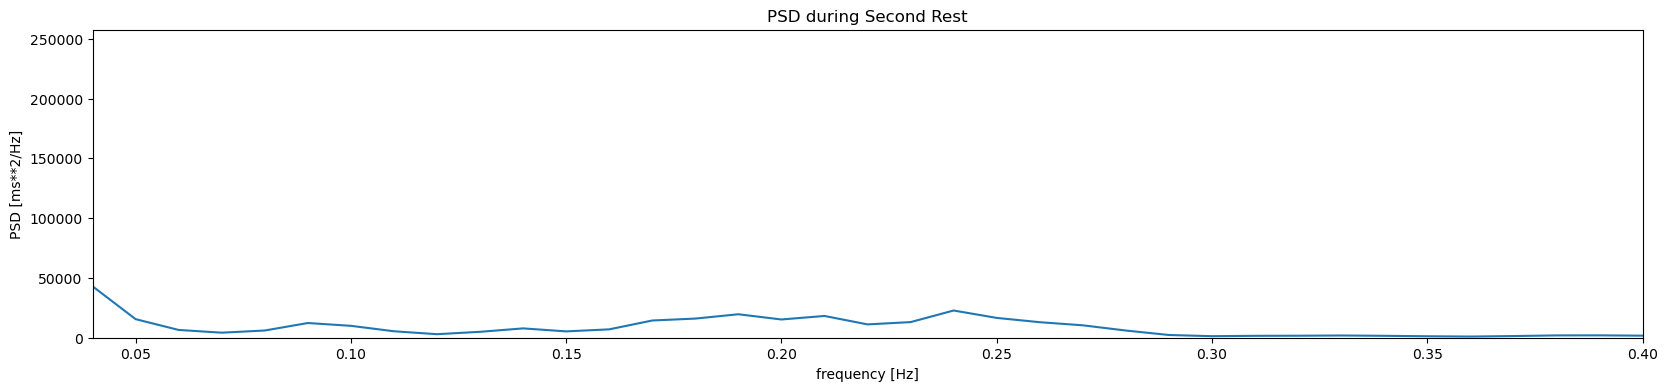

Absolute Power LF =  123924.21305070256 ms**2/Hz
Absolute Power HF =  208168.7878733796 ms**2/Hz
Total Power =  879556.3187010923 ms**2/Hz
LF/HF Ratio =  0.595306406482419
Normalized Power LF =  14.089400577976733 %
Normalized Power HF =  23.66747682295072 %
Normalized LF/HF Ratio =  0.595306406482419 %


In [ ]:
nperseg = 100000
noverlap = nperseg*2/3

f_den, Pxx_den = sg.welch(y_secondrest,fs,nperseg = nperseg, noverlap=noverlap)
plt.figure(figsize = (20,4), dpi = 100)
plt.plot(f_den, Pxx_den)
plt.xlim(0.04, 0.4)
plt.ylim(bottom=0)
plt.title('PSD during Second Rest')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [ms**2/Hz]')
plt.show()

idx_lf = np.where((0.04 <= f_den) & (f_den <= 0.15))
idx_hf = np.where((0.15 <= f_den) & (f_den <= 0.40))
idx_lfhf = np.where((0.04 <= f_den) & (f_den <= 0.40))
idx_tot_power = np.where((0 <= f_den) & (f_den <= 0.40))

abs_power_LF = np.sum(np.abs(Pxx_den[idx_lf]))
abs_power_HF = np.sum(np.abs(Pxx_den[idx_hf]))
tot_power = np.sum(np.abs(Pxx_den[idx_tot_power]))

print('Absolute Power LF = ', abs_power_LF, 'ms**2/Hz')
print('Absolute Power HF = ',  abs_power_HF, 'ms**2/Hz')
print('Total Power = ', tot_power, 'ms**2/Hz' )

lf_hf_ratio = abs_power_LF/abs_power_HF
print('LF/HF Ratio = ', lf_hf_ratio)

norm_power_LF = (abs_power_LF/tot_power)*100
norm_power_HF = (abs_power_HF/tot_power)*100
norm_lf_hf_ratio = norm_power_LF/norm_power_HF
print('Normalized Power LF = ', norm_power_LF, '%')
print('Normalized Power HF = ',  norm_power_HF, '%')
print('Normalized LF/HF Ratio = ', norm_lf_hf_ratio, '%')

In [ ]:
import math

# Parameters for segmentation and analysis
segment_length = 10*fs  # seconds
overlap = int(segment_length*0.9)  # seconds

# Calculate LF/HF ratio over time
lfhf_ratio = []
hf_over_time = []
lf_over_time = []

for i in range(0, len(y_vals), segment_length - overlap):
    segment = y_vals[i:i + segment_length]

    # Compute PSD using Welch's method
    f_den, Pxx_den = sg.welch(segment, fs=fs, nperseg = 10000)

    idx_lf = np.where((0.04 <= f_den) & (f_den <= 0.15))
    idx_hf = np.where((0.15 <= f_den) & (f_den <= 0.40))

    # Calculate LF and HF power
    abs_power_LF = np.sum(np.abs(Pxx_den[idx_lf]))
    abs_power_HF = np.sum(np.abs(Pxx_den[idx_hf]))
    lf_hf_ratio = abs_power_LF / abs_power_HF

    # Calculate LF/HF ratio
    if math.isnan(lf_hf_ratio) == False:
        lfhf_ratio.append(lf_hf_ratio)
    if math.isnan(abs_power_HF) == False:
        hf_over_time.append(abs_power_HF)
    if math.isnan(abs_power_LF) == False:
        lf_over_time.append(abs_power_LF)


c:\Users\Jeremi\anaconda3\envs\mne\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 10000 is greater than input length  = 9361, using nperseg = 9361
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\Users\Jeremi\anaconda3\envs\mne\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 10000 is greater than input length  = 8361, using nperseg = 8361
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\Users\Jeremi\anaconda3\envs\mne\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 10000 is greater than input length  = 7361, using nperseg = 7361
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\Users\Jeremi\anaconda3\envs\mne\lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 10000 is greater than input length  = 6361, using nperseg = 6361
  warnings.warn('nperseg = {0:d} is greater than input length '
c:\Users\Jeremi\anaconda3\envs\mne\lib\s

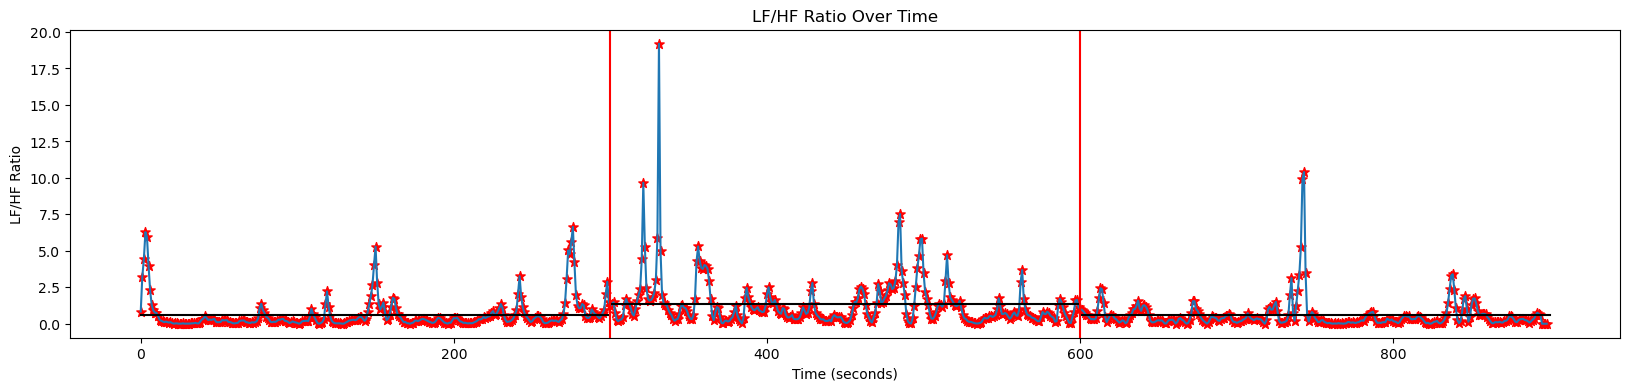

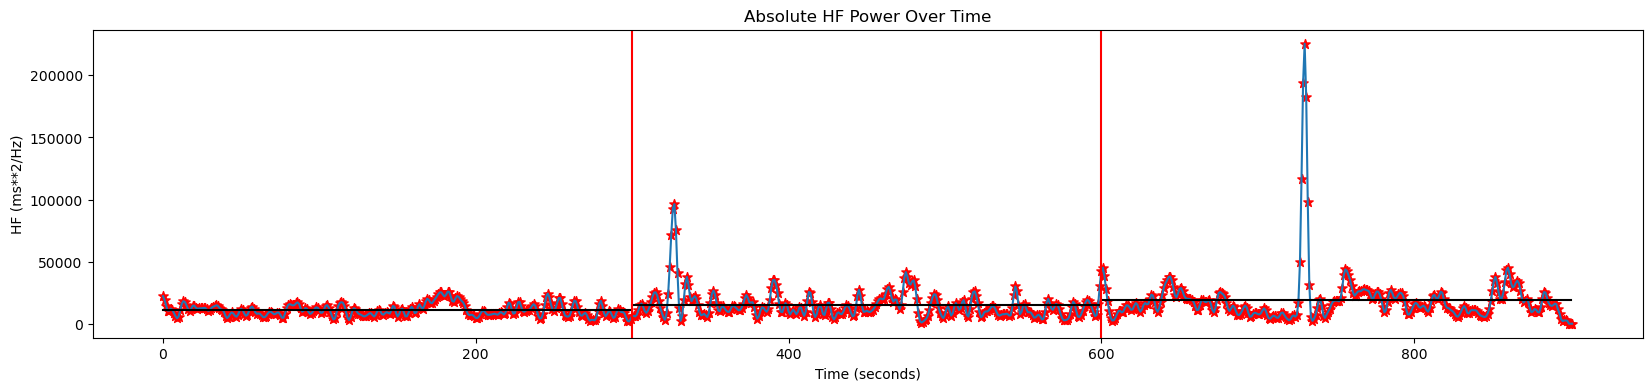

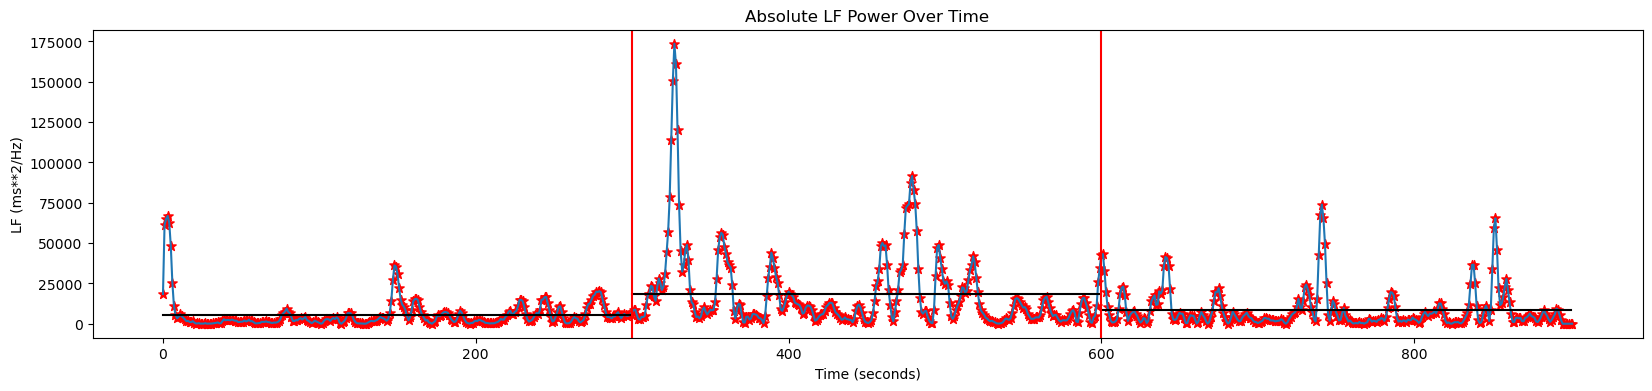

In [ ]:
# Plot LF/HF ratio over time
plt.figure(figsize = (20,4))
plt.plot(np.arange(0, len(lfhf_ratio)*(segment_length - overlap), segment_length - overlap)/fs, lfhf_ratio)
plt.plot((0, 300), (np.average(lfhf_ratio[0:300]),np.average(lfhf_ratio[0:300])), 'k-')
plt.plot((300, 600), (np.average(lfhf_ratio[300:600]),np.average(lfhf_ratio[300:600])), 'k-')
plt.plot((600, 900), (np.average(lfhf_ratio[600:]),np.average(lfhf_ratio[600:])), 'k-')
plt.scatter(np.arange(0, len(lfhf_ratio)*(segment_length - overlap), segment_length - overlap)/fs, lfhf_ratio, color = 'red', s = 50, marker= '*')
plt.axvline(x = 300, color = 'r')
plt.axvline(x = 600, color = 'r')
plt.xlabel('Time (seconds)')
plt.ylabel('LF/HF Ratio')
plt.title('LF/HF Ratio Over Time')
plt.show()

# Plot HF over time
plt.figure(figsize = (20,4))
plt.plot(np.arange(0, len(hf_over_time)*(segment_length - overlap), segment_length - overlap)/fs, hf_over_time)
plt.plot((0, 300), (np.average(hf_over_time[0:300]),np.average(hf_over_time[0:300])), 'k-')
plt.plot((300, 600), (np.average(hf_over_time[300:600]),np.average(hf_over_time[300:600])), 'k-')
plt.plot((600, 900), (np.average(hf_over_time[600:]),np.average(hf_over_time[600:])), 'k-')
plt.scatter(np.arange(0, len(hf_over_time)*(segment_length - overlap), segment_length - overlap)/fs, hf_over_time, color = 'red', s = 50, marker ='*')
plt.axvline(x = 300, color = 'r')
plt.axvline(x = 600, color = 'r')
plt.xlabel('Time (seconds)')
plt.ylabel('HF (ms**2/Hz)')
plt.title('Absolute HF Power Over Time')
plt.show()

# Plot LF over time
plt.figure(figsize = (20,4))
plt.plot(np.arange(0, len(lf_over_time)*(segment_length - overlap), segment_length - overlap)/fs, lf_over_time)
plt.plot((0, 300), (np.average(lf_over_time[0:300]),np.average(lf_over_time[0:300])), 'k-')
plt.plot((300, 600), (np.average(lf_over_time[300:600]),np.average(lf_over_time[300:600])), 'k-')
plt.plot((600, 900), (np.average(lf_over_time[600:]),np.average(lf_over_time[600:])), 'k-')
plt.scatter(np.arange(0, len(lf_over_time)*(segment_length - overlap), segment_length - overlap)/fs, lf_over_time, color = 'red', s = 50, marker ='*')
plt.axvline(x = 300, color = 'r')
plt.axvline(x = 600, color = 'r')
plt.xlabel('Time (seconds)')
plt.ylabel('LF (ms**2/Hz)')
plt.title('Absolute LF Power Over Time')
plt.show()

##### PSD Measurement using Full FFT

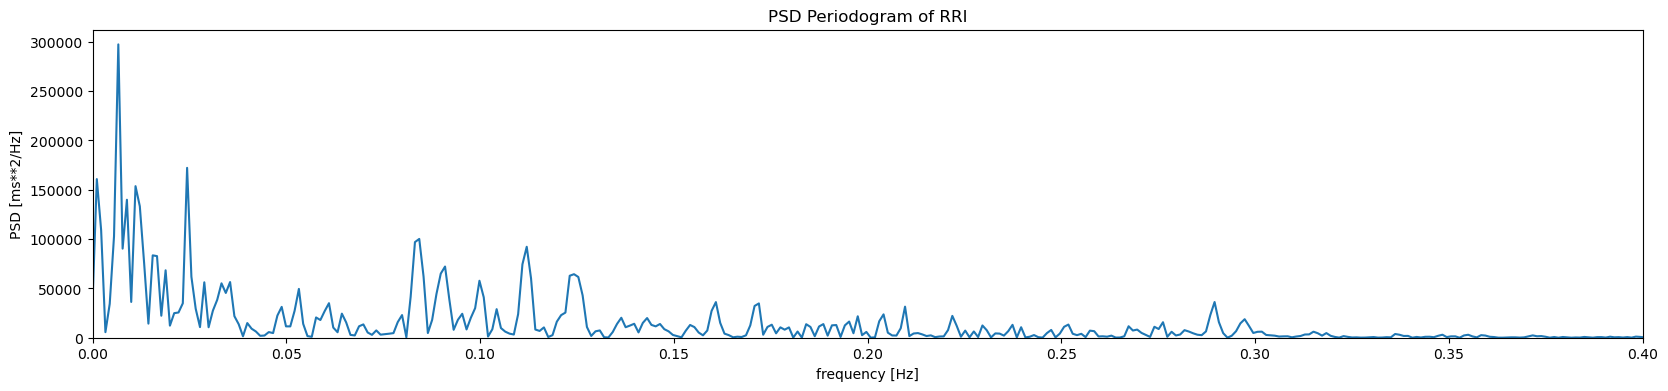

In [ ]:
#PSD Measurement using Full FFT
f, Pxx_den = sg.periodogram(y_vals,fs,window = 'hann')
plt.figure(figsize = (20,4), dpi = 100)
plt.plot(f, Pxx_den)
plt.xlim(0, 0.4)
plt.ylim(bottom=0)
plt.title('PSD Periodogram of RRI')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [ms**2/Hz]')
plt.show()

#### Time Analysis

In [ ]:
#Measure SDNN
sdnn_full = np.std(y_vals)
sdnn_rest_1 = np.std(y_firstrest)
sdnn_test = np.std(y_stress)
sdnn_rest_2 = np.std(y_secondrest)
print("Standard Deviation during Experiment: ", sdnn_full)
print("Standard Deviation during First Rest: ", sdnn_rest_1)
print("Standard Deviation during CSWT: ", sdnn_test)
print("Standard Deviation during Second Rest: ", sdnn_rest_2)

Standard Deviation during Experiment:  83.82597159669619
Standard Deviation during First Rest:  74.4544065452415
Standard Deviation during CSWT:  76.94781946561727
Standard Deviation during Second Rest:  94.08376470481016


#### Time-Frequency Analysis

##### STFT

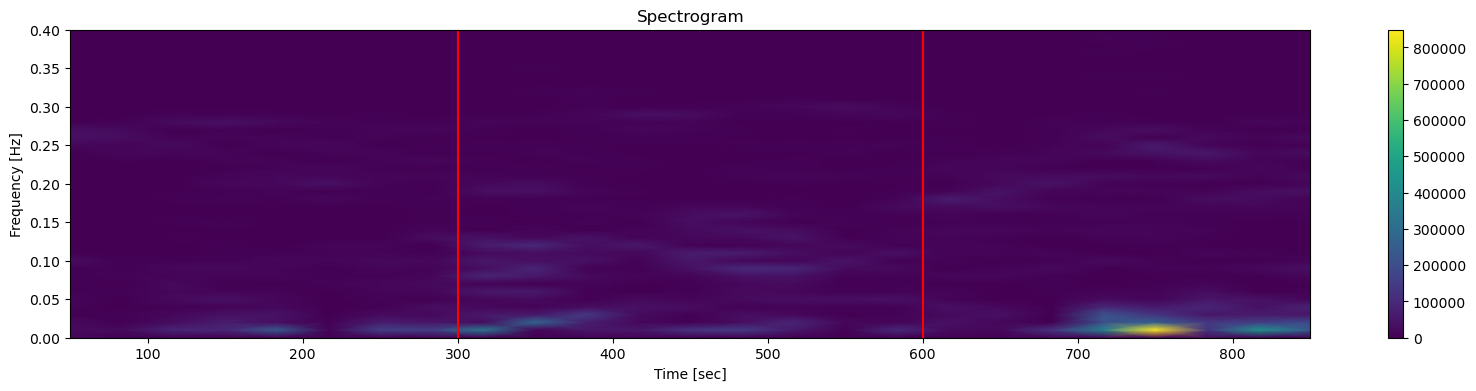

In [ ]:
#STFT RRI
nperseg = 100000
noverlap = nperseg*2/3
f1,t1,Sxx = scipy.signal.spectrogram(y_vals, fs=fs, nperseg = nperseg, noverlap = noverlap, scaling='density')
plt.figure(figsize = (20,4), dpi = 100)
plt.pcolormesh(t1, f1, np.abs(Sxx), shading='gouraud', snap= True)
plt.title('Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.axis([t1[0], t1[-1], 0, 0.4])
plt.axvline(x = 300, color = 'r')
plt.axvline(x = 600, color = 'r')
plt.colorbar()
plt.show()

### Using ECG Detectors

## EEG Analysis

In [5]:
#raw_eeg = raw.copy().crop(tmin = 39.471, tmax = 939.971).pick_types(eeg=True, eog=False, ecg=False) #make a copy
# raw_temp_short = raw.copy().crop(tmin=339.471, tmax = 519.471)

raw_temp = raw.copy().crop(tmin = 17.101, tmax = 918.461) #make a copy

# eeg_firstrest = raw.copy().crop(tmin = 39.471, tmax = 339.471)
# eeg_stress = raw.copy().crop(tmin = 339.471, tmax = 639.471)
# eeg_secondrest = raw.copy().crop(tmin = 639.471, tmax = 939.971)

### Preprocessing: ICA 

In [6]:
#Regular Expression = Search certain pattern
regexp = r"(ECG|vEOG|hEOG)"
artifact_picks = mne.pick_channels_regexp(raw_temp.ch_names, regexp=regexp)
# raw_temp.plot(order=artifact_picks, n_channels=len(artifact_picks), show_scrollbars=False)

##### Visualizing Artifact

Using EOG channels: vEOG, hEOG
EOG channel index for this subject is: [64 65]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel hEOG for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 191 significant peaks
Number of EOG events detected: 191
Not setting metadata
191 matching events found
No baseline correction applied
Loading data for 191 events and 1001 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legac

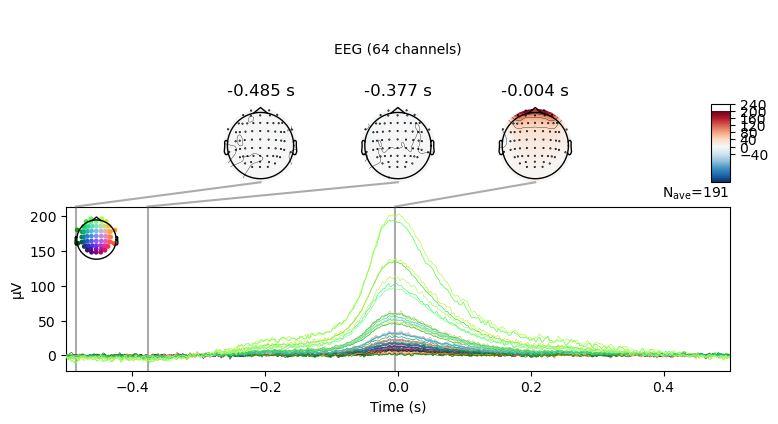

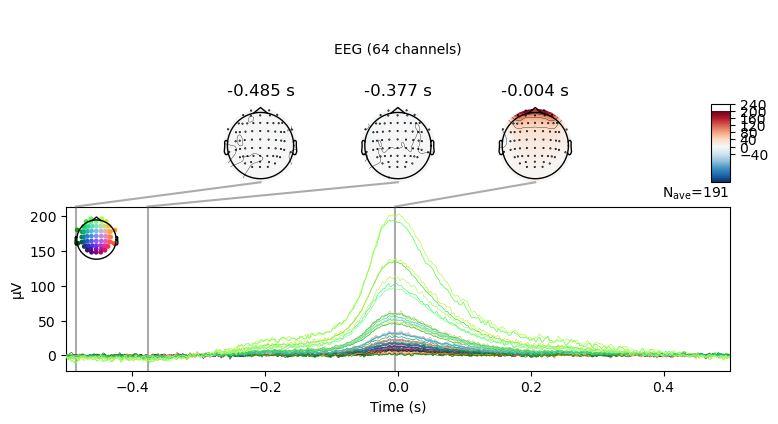

In [7]:
eog_evoked = create_eog_epochs(raw_temp).average()
eog_evoked.apply_baseline(baseline=(None, -0.2))
eog_evoked.plot_joint()

Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 965 (average pulse 64 / min.)
Not setting metadata
965 matching events found
No baseline correction applied
Loading data for 965 events and 1001 original time points ...
0 bad epochs dropped
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.
NOTE: pick_channels() is a legacy function.

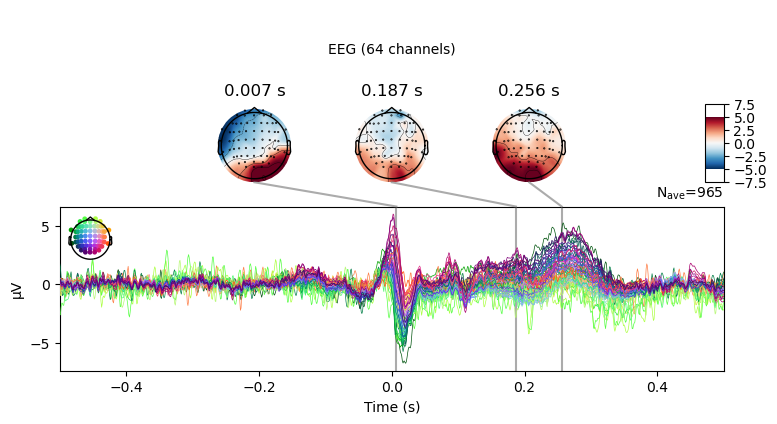

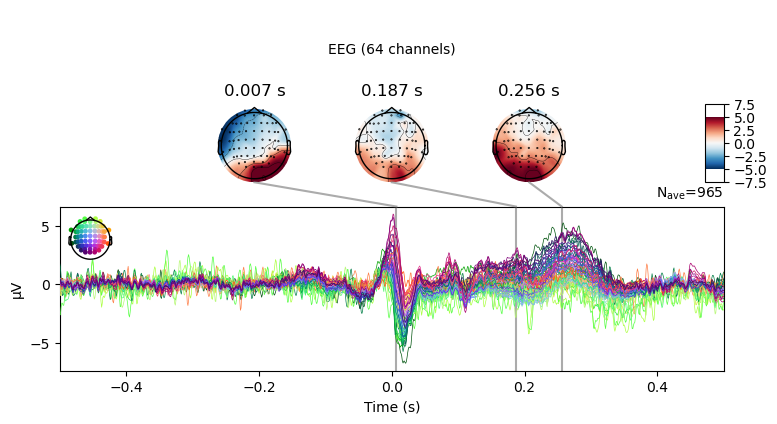

In [8]:
ecg_evoked = create_ecg_epochs(raw_temp).average()
ecg_evoked.apply_baseline(baseline=(None, -0.2))
ecg_evoked.plot_joint()

##### Filtering to Remove Slow Drifts

In [7]:
filt_raw = raw_temp.load_data().copy().filter(l_freq=1.0, h_freq=None)

Reading 0 ... 901360  =      0.000 ...   901.360 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.6s finished


##### Extracting PCA

In [8]:
ica = ICA(n_components=32, max_iter="auto", random_state = 95) 
ica.fit(filt_raw)
ica

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 32 components
Fitting ICA took 84.1s.


<ICA | raw data decomposition, method: fastica (fit in 53 iterations on 901361 samples), 32 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>

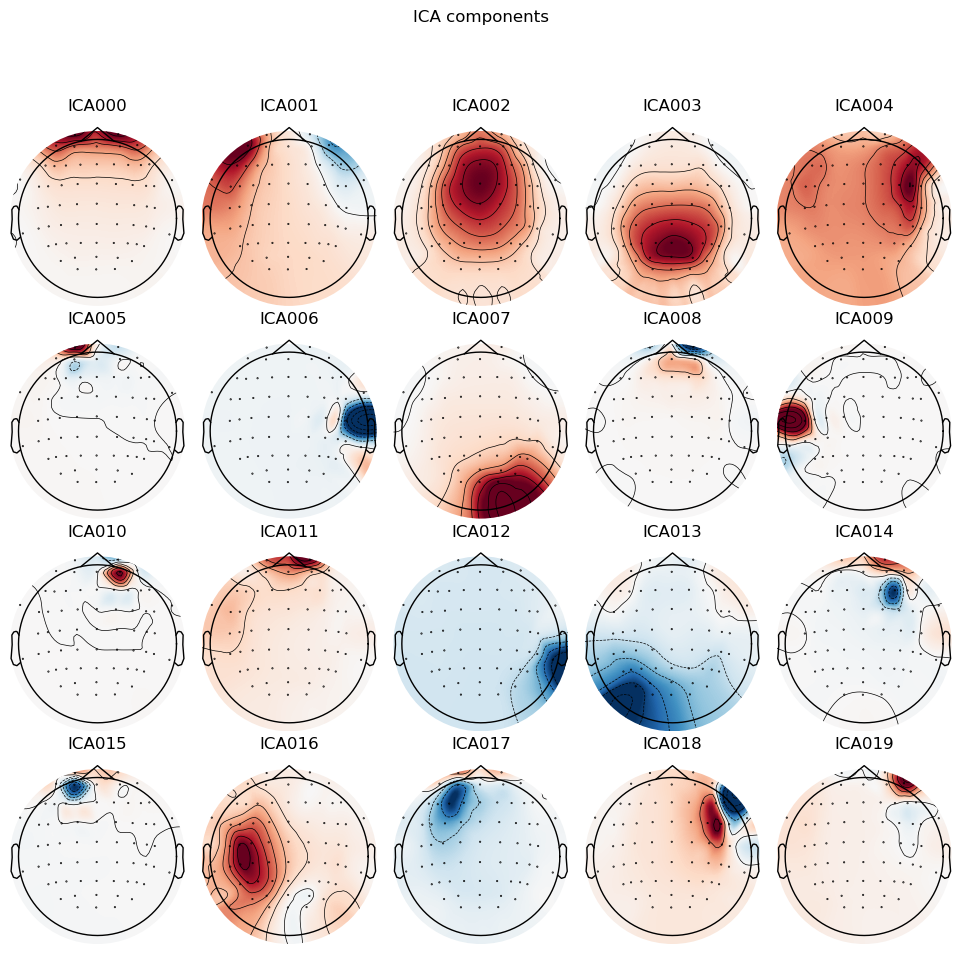

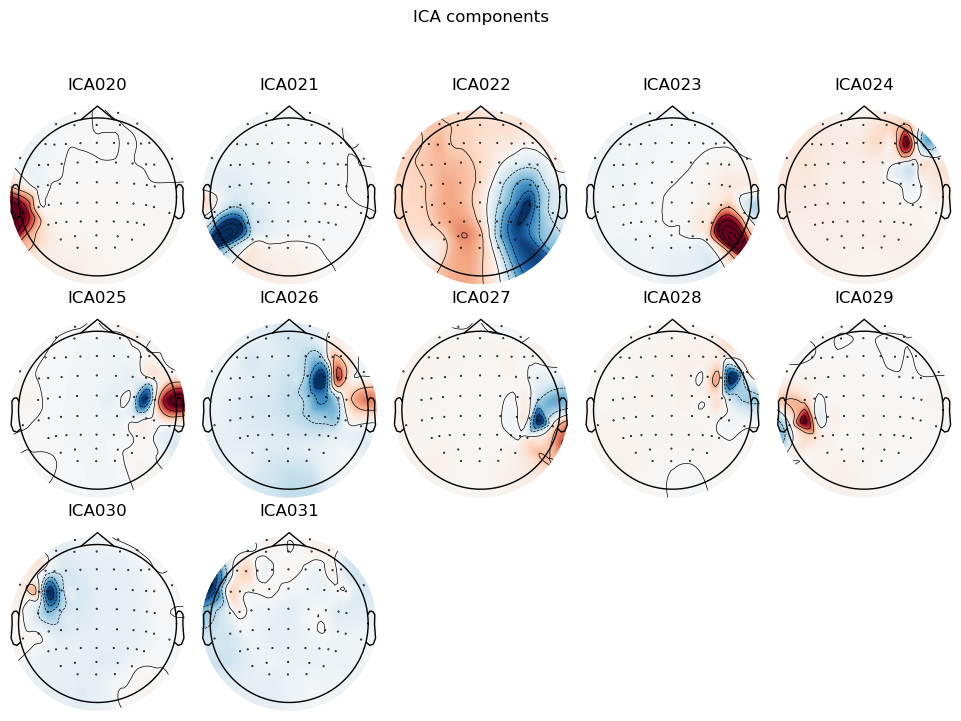

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x731.5 with 12 Axes>]

In [9]:
# ica.plot_sources(raw_temp, show_scrollbars=False)
ica.plot_components()

##### Check Blinks PCA

In [21]:
# Remove blinks PCA
eog_indices, eog_scores = ica.find_bads_eog(raw_temp, ch_name=['vEOG', 'hEOG'], threshold = 0.8, measure='correlation')
# ica.plot_overlay(raw_temp, exclude=eog_indices, picks="eeg")
# ica.exclude = eog_indices

# ica.plot_properties(raw_temp, picks=eog_indices)
# ica.plot_scores(eog_scores)

Using EOG channels: vEOG, hEOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)



[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


##### Check ECG PCA

Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 965 (average pulse 64 / min.)
Not setting metadata
965 matching events found
No baseline correction applied
Using data from preloaded Raw for 965 events and 1001 original time points ...
0 bad epochs dropped
Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 1 ICA component
    Projecting back using 64 PCA components


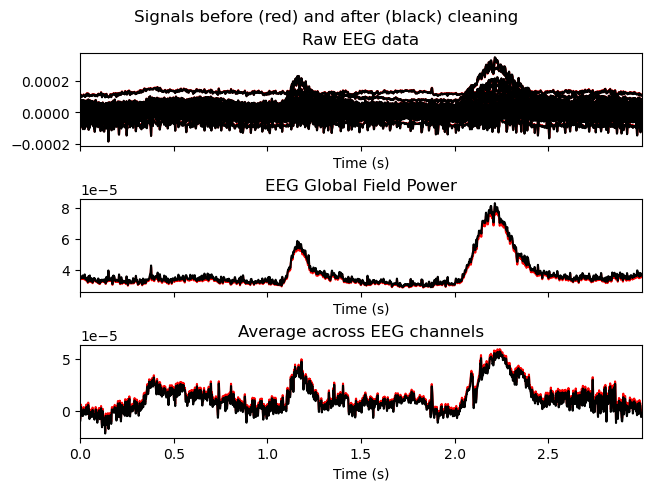

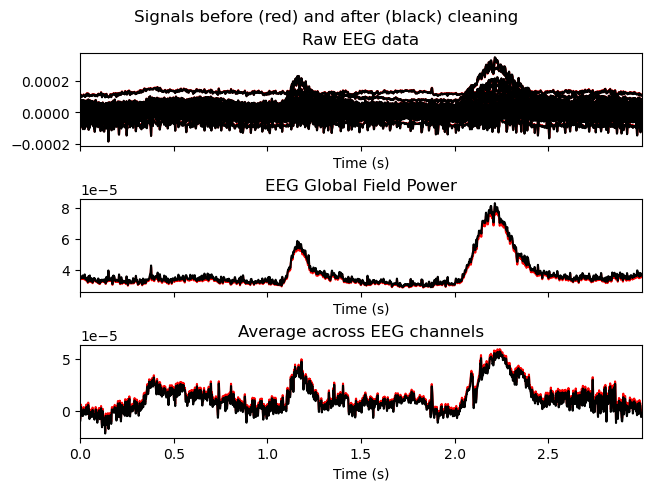

In [14]:
#Remove heart beat PCA
ecg_indices, ecg_scores = ica.find_bads_ecg(raw_temp, ch_name='ECG',threshold = 0.8, measure='correlation')
ica.plot_overlay(raw_temp, exclude=ecg_indices, picks="eeg")
#ica.exclude = ecg_indices

# ica.plot_properties(raw_temp, picks=ecg_indices)
# ica.plot_scores(ecg_scores)

Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 s)

Number of ECG events detected : 965 (average pulse 64 / min.)
Not setting metadata
965 matching events found
No baseline correction applied
Using data from preloaded Raw for 965 events and 1001 original time points ...
0 bad epochs dropped
[]
['ICA000', 'ICA001', 'ICA002', 'ICA003', 'ICA004', 'ICA005', 'ICA006', 'ICA007', 'ICA008', 'ICA009', 'ICA010', 'ICA011', 'ICA012', 'ICA013', 'ICA014', 'ICA015', 'ICA016', 'ICA017', 'ICA018', 'ICA019', 'ICA020', 'ICA021', 'ICA022

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


['Fp1', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT9', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'FT10', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP9', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'TP10', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'vEOG', 'hEOG', 'ECG']
[[0.0003418 0.0003443 0.0003466 ... 0.0003714 0.0003689 0.0003665]]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 4.00 Hz (-6

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


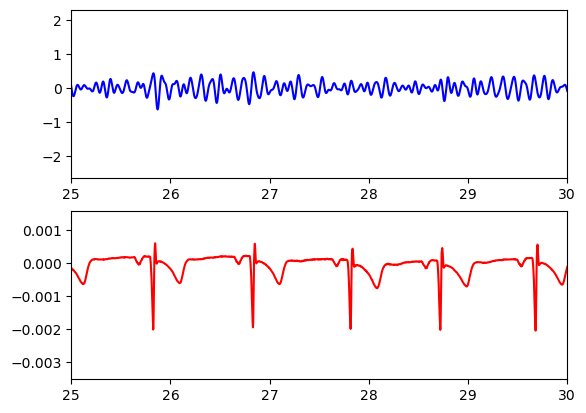

In [15]:
## Code by Simon to compare ECG data and IC components
ecg_indices, ecg_scores = ica.find_bads_ecg(raw_temp, ch_name='ECG', threshold = 0.9, measure='correlation')
sources = ica.get_sources(raw_temp)

import matplotlib.pyplot as plt

print(ecg_indices)
print(sources.ch_names)

ics = list()
for idx in ecg_indices:
    ics.append("ICA0%d"%idx)

print(ics)

#ecg_IC = sources.copy().filter(l_freq = 8, h_freq = 16).get_data(picks=ics)
ecg_data = raw_temp.copy().filter(l_freq = 8, h_freq = 16).get_data(picks='ECG')

print(raw_temp.ch_names)
print(ecg_data)

xlim = [25, 30]

#plt.figure()
f, (ax1, ax2) = plt.subplots(2, 1)
ecg_IC = sources.copy().filter(l_freq = 8, h_freq = 16).get_data(picks="ICA031")
ax1.plot(raw_temp.times, np.squeeze(ecg_IC), 'b')
ax1.set_xlim(xlim)
ax2.plot(raw_temp.times, np.squeeze(ecg_data), 'r')
ax2.set_xlim(xlim)



#for idx in ecg_indices:
    #ics.append("ICA0%d"%idx)
#ecg_IC = sources.copy().filter(l_freq = 8, h_freq = 16).get_data(picks="ICA021")
#plt.plot(raw_temp.times, np.squeeze(ecg_IC), 'b')
#plt.xlim(xlim)
#plt.figure()
#plt.plot(raw_temp.times, np.squeeze(ecg_data), 'r')
#plt.xlim(xlim)
plt.show()




##### Apply ICA

In [33]:
# ica.exclude = [0,1,5,6,7,8,9,10,11,12,14,15,19,20,21,23,25,27]
ica.exclude = [0,1,5,6,7,8,9,10,12,14,15,20,21,23,25,27]
# ica.exclude = eog_indices
#Prominent EOG artifact: 0, 1
#Close to EOG: 5, 8, 10, 15, 14
#Unknown: 10,14,15
#Suspected Muscle: 6,9,12,20,21,25, 27, (29 =>Relate with TP7, but doesnt really affecting the PSD)

In [34]:
# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = raw_temp.copy()
ica.apply(reconst_raw)

Applying ICA to Raw instance
    Transforming to ICA space (32 components)
    Zeroing out 16 ICA components
    Projecting back using 64 PCA components


<RawBrainVision | 20240129_mat5mins_001.eeg, 67 x 901361 (901.4 s), ~460.8 MB, data loaded>

In [47]:
# reconst_raw.copy().pick(['TP9','TP7','P7']).plot(title = 'Reconstructed')
# raw_temp.copy().pick(['TP9','TP7','P7']).plot(title = 'Raw')

reconst_raw.plot(title = 'Reconstructed')
raw_temp.plot(title = 'Raw')

In [35]:
#Split After ICA Data into each segments

ica_firstrest = reconst_raw.copy().crop(tmin = 0, tmax = 300)
ica_stress = reconst_raw.copy().crop(tmin = 300, tmax = 600)
ica_secondrest = reconst_raw.copy().crop(tmin = 600)

### Preprocessing: Regression

In [40]:
from mne.preprocessing import EOGRegression

raw_regression = raw_temp.copy().filter(0.3, 40) 
raw_regression.set_eeg_reference("average")
model_plain = EOGRegression(picks="eeg", picks_artifact="eog").fit(raw_regression)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 11001 samples (11.001 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.6s finished


No projector specified for this dataset. Please consider the method self.add_proj.


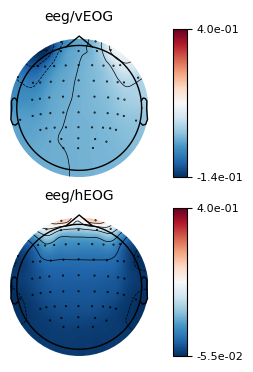

In [41]:
fig = model_plain.plot(vlim=(None, 0.4))  # regression coefficients as topomap
fig.set_size_inches(3, 2)

### Frequency Analysis

##### EEG Frequency Band Plot

In [19]:
alpha_band_raw = raw_temp.copy().filter(l_freq=8, h_freq=13, method='fir', verbose=False)
beta_band_raw = raw_temp.copy().filter(l_freq=13, h_freq=30, method='fir', verbose=False)
gamma_band_raw = raw_temp.copy().filter(l_freq=30, h_freq=40, method='fir', verbose=False)
theta_band_raw = raw_temp.copy().filter(l_freq=4, h_freq=8, method='fir', verbose=False)

In [20]:
alpha_band_reconst = reconst_raw.copy().filter(l_freq=8, h_freq=13, method='fir', verbose=False)
beta_band_reconst = reconst_raw.copy().filter(l_freq=13, h_freq=30, method='fir', verbose=False)
gamma_band_reconst = reconst_raw.copy().filter(l_freq=30, h_freq=40, method='fir', verbose=False)
theta_band_reconst = reconst_raw.copy().filter(l_freq=4, h_freq=8, method='fir', verbose=False)

In [21]:
#Comparison between before and after ICA
theta_band_raw.plot(title = 'Raw')
theta_band_reconst.plot(title = 'Reconstructed')

##### PSD Analysis on EEG

Effective window size : 0.256 (s)


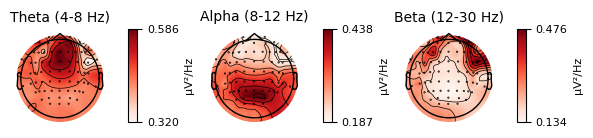

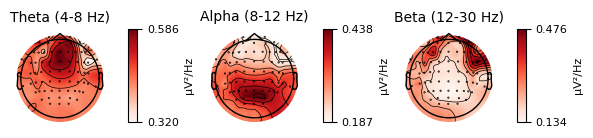

In [36]:
eeg_psd = reconst_raw.compute_psd(method='welch',fmin=4,fmax=30)
eeg_psd.plot_topomap(bands = {'Theta (4-8 Hz)': (4, 8),'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30)}, normalize = True, ch_type='eeg')
#eeg_psd.plot()

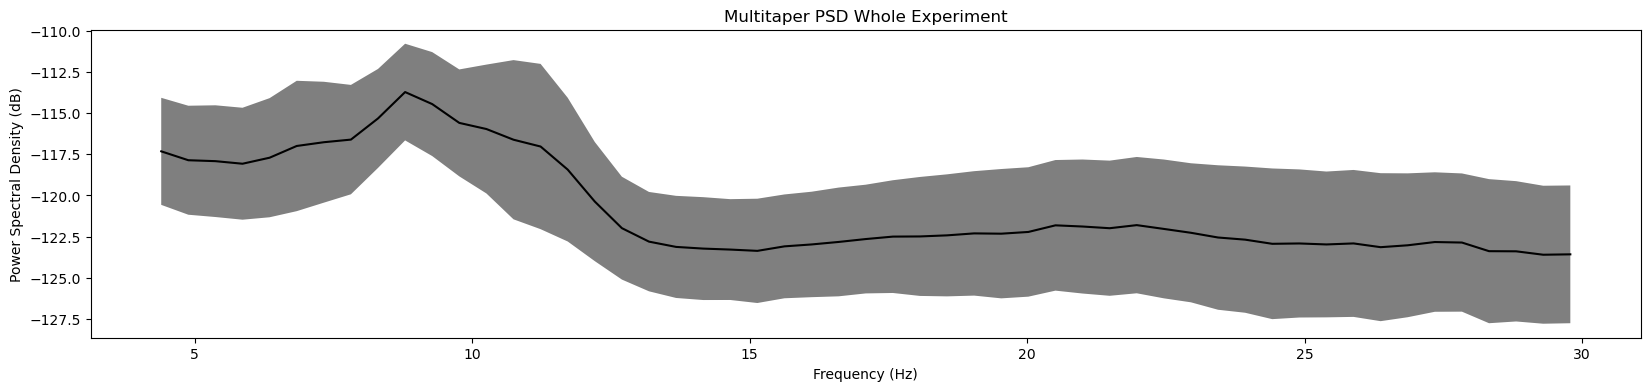

In [85]:
psds, freqs = eeg_psd.get_data(return_freqs=True)
#then convert to dB and take mean & standard deviation across channels
psds = 10 * np.log10(psds)
psds_mean = psds.mean(axis=0)
psds_std = psds.std(axis=0)


plt.figure(figsize = (20,4), dpi=100)
plt.title("Multitaper PSD Whole Experiment")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (dB)")
plt.plot(freqs, psds_mean, color="k")
plt.fill_between(
    freqs,
    psds_mean - psds_std,
    psds_mean + psds_std,
    color="k",
    alpha=0.5,
    edgecolor="none",
)
del(psds,psds_mean,psds_std, freqs)

Effective window size : 100.000 (s)


c:\Users\Jeremi\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


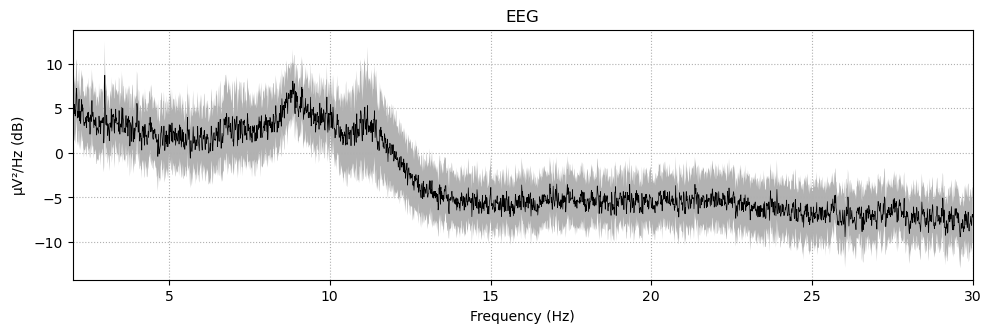

In [60]:
nperseg = 100000
noverlap = int(nperseg*2/3)
reconst_raw.compute_psd(method ='welch',fmin= 2.0, fmax = 30, n_fft = nperseg, n_overlap = noverlap, n_per_seg = nperseg).plot(average = True, picks = 'eeg')

Effective window size : 0.256 (s)


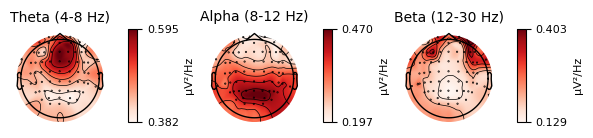

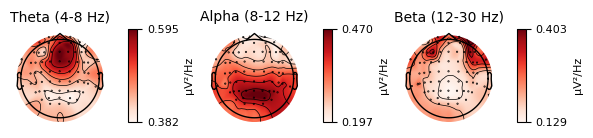

In [37]:
psd_firstrest = ica_firstrest.compute_psd(method='welch',fmin=4,fmax=30)
psd_firstrest.plot_topomap(bands = {'Theta (4-8 Hz)': (4, 8),'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30)}, normalize = True, ch_type='eeg')

Effective window size : 100.000 (s)


c:\Users\Jeremi\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


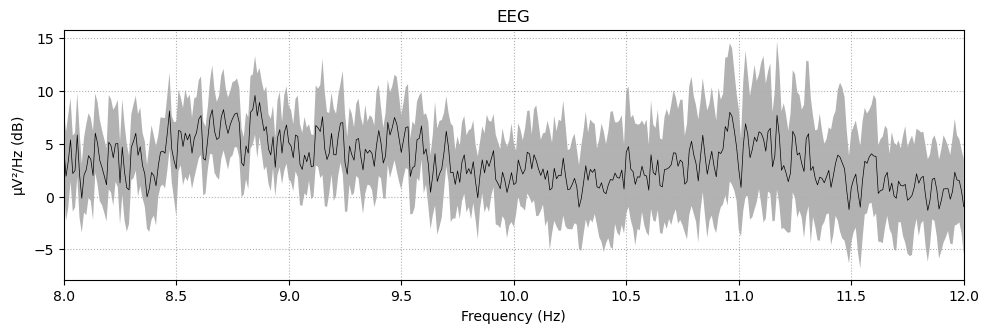

In [66]:
nperseg = 100000
noverlap = int(nperseg*2/3)
ica_firstrest.compute_psd(method ='welch',fmin= 8.0, fmax = 12, n_fft = nperseg, n_overlap = noverlap, n_per_seg = nperseg).plot(average = True, picks = 'eeg')

In [75]:
psds,freqs = ica_firstrest.compute_psd(method ='welch',fmin= 8.0, fmax = 12, n_fft = nperseg, n_overlap = noverlap, n_per_seg = nperseg)

Effective window size : 100.000 (s)


ValueError: too many values to unpack (expected 2)

In [52]:
psds, freqs = psd_firstrest.get_data(return_freqs=True)
#then convert to dB and take mean & standard deviation across channels
psds = 10 * np.log10(psds)
psds_mean = psds.mean(axis=0)
psds_std = psds.std(axis=0)


plt.figure(figsize = (20,4), dpi=100)
plt.title("Multitaper PSD First Rest")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (dB)")
plt.plot(freqs, psds_mean, color="k")
plt.fill_between(
    freqs,
    psds_mean - psds_std,
    psds_mean + psds_std,
    color="k",
    alpha=0.5,
    edgecolor="none",
)
# del(psds,psds_mean,psds_std, freqs)

Effective window size : 0.256 (s)


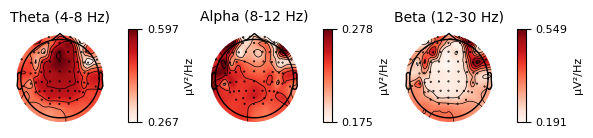

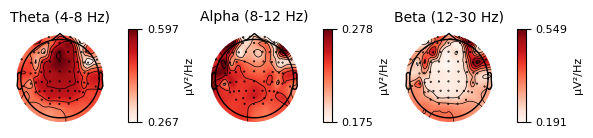

In [38]:
psd_stress = ica_stress.compute_psd(method='welch',fmin=4,fmax=30)
psd_stress.plot_topomap(bands = {'Theta (4-8 Hz)': (4, 8),'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30)}, normalize = True, ch_type='eeg')

Effective window size : 100.000 (s)


c:\Users\Jeremi\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


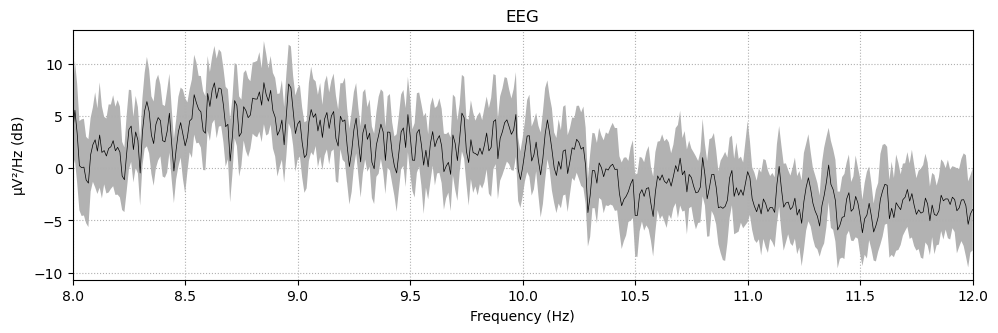

In [65]:
nperseg = 100000
noverlap = int(nperseg*2/3)
ica_stress.compute_psd(method ='welch',fmin= 8.0, fmax = 12, n_fft = nperseg, n_overlap = noverlap, n_per_seg = nperseg).plot(average = True, picks = 'eeg')

In [50]:
psds, freqs = psd_stress.get_data(return_freqs=True)
#then convert to dB and take mean & standard deviation across channels
psds = 10 * np.log10(psds)
psds_mean = psds.mean(axis=0)
psds_std = psds.std(axis=0)


plt.figure(figsize = (20,4), dpi=100)
plt.title("Multitaper PSD Stress Test")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (dB)")
plt.plot(freqs, psds_mean, color="k")
plt.fill_between(
    freqs,
    psds_mean - psds_std,
    psds_mean + psds_std,
    color="k",
    alpha=0.5,
    edgecolor="none",
)
del(psds,psds_mean,psds_std, freqs)

Effective window size : 0.256 (s)


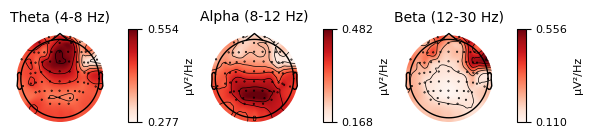

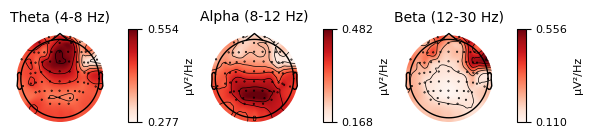

In [39]:
psd_secondrest = ica_secondrest.compute_psd(method='welch',fmin=4,fmax=30)
psd_secondrest.plot_topomap(bands = {'Theta (4-8 Hz)': (4, 8),'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30)}, normalize = True, ch_type='eeg')

Effective window size : 100.000 (s)


c:\Users\Jeremi\anaconda3\envs\mne\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


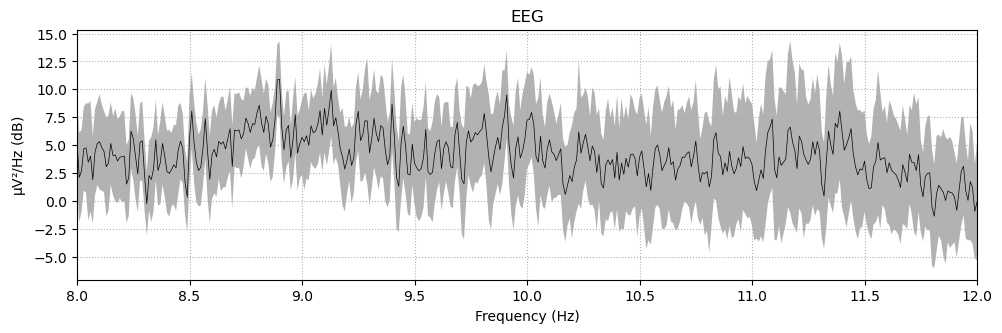

In [64]:
nperseg = 100000
noverlap = int(nperseg*2/3)
ica_secondrest.compute_psd(method ='welch',fmin= 8.0, fmax = 12, n_fft = nperseg, n_overlap = noverlap, n_per_seg = nperseg).plot(average = True, picks = 'eeg')

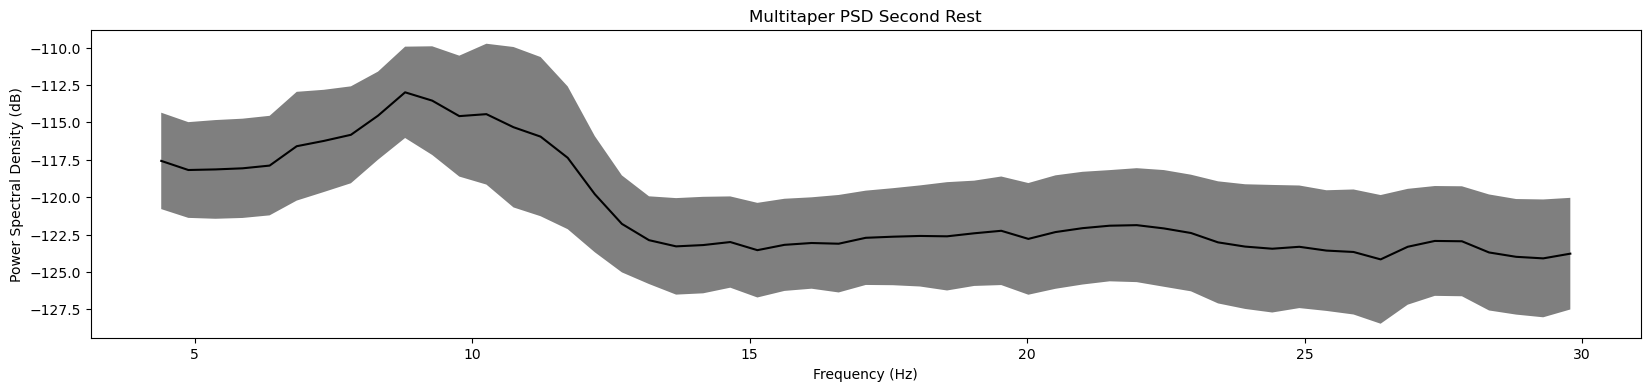

In [79]:
psds, freqs = psd_secondrest.get_data(return_freqs=True)
#then convert to dB and take mean & standard deviation across channels
psds = 10 * np.log10(psds)
psds_mean = psds.mean(axis=0)
psds_std = psds.std(axis=0)


plt.figure(figsize = (20,4), dpi=100)
plt.title("Multitaper PSD Second Rest")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (dB)")
plt.plot(freqs, psds_mean, color="k")
plt.fill_between(
    freqs,
    psds_mean - psds_std,
    psds_mean + psds_std,
    color="k",
    alpha=0.5,
    edgecolor="none",
)
del(psds,psds_mean,psds_std, freqs)

##### Other

In [27]:
epochs = mne.Epochs(reconst_raw, events, tmin=-0.2, tmax = 1, preload=True, reject = None)

Not setting metadata
47 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 47 events and 1201 original time points ...
5 bad epochs dropped


In [28]:
eeg_temp = reconst_raw.copy().pick_types(eeg=True, eog=False, ecg=False)
channel = eeg_temp.ch_names

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


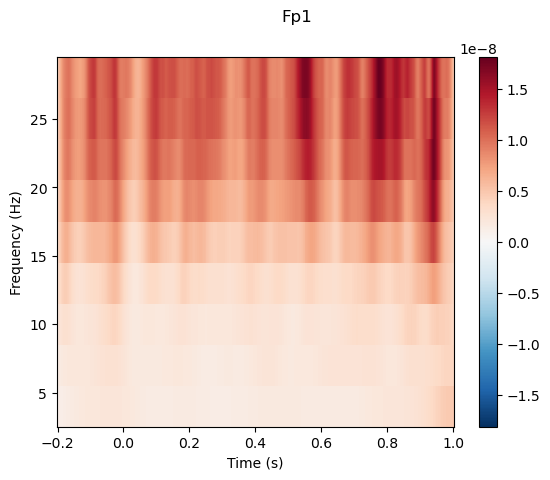

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


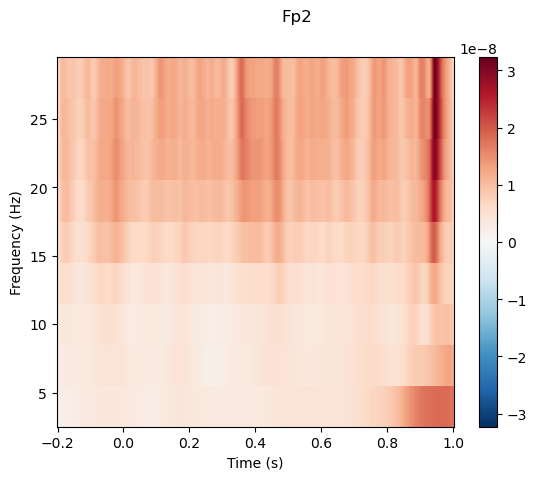

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


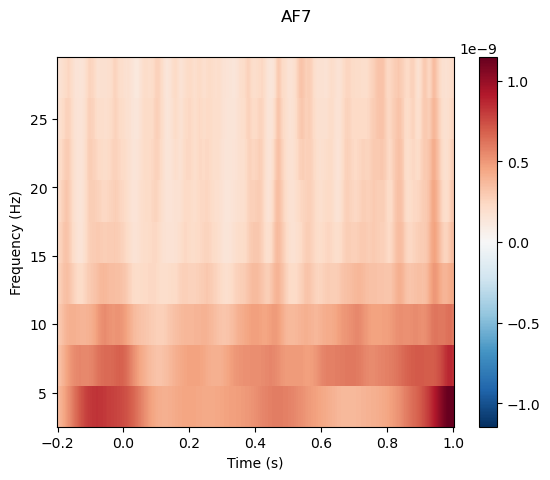

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


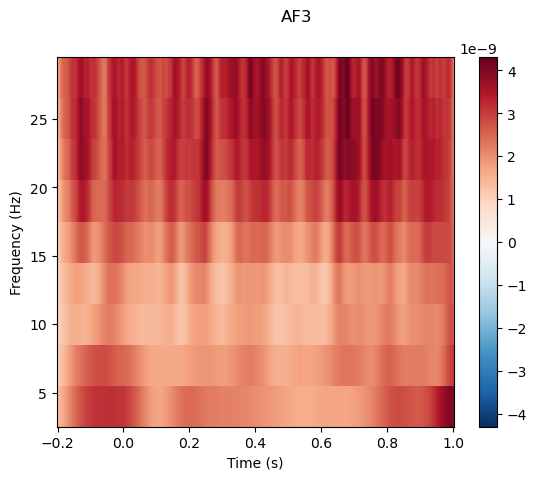

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


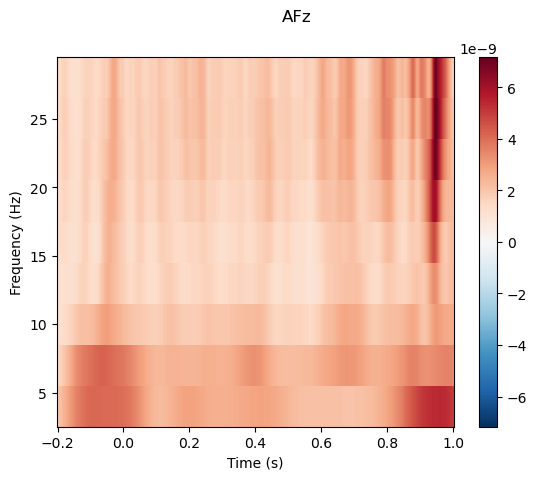

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


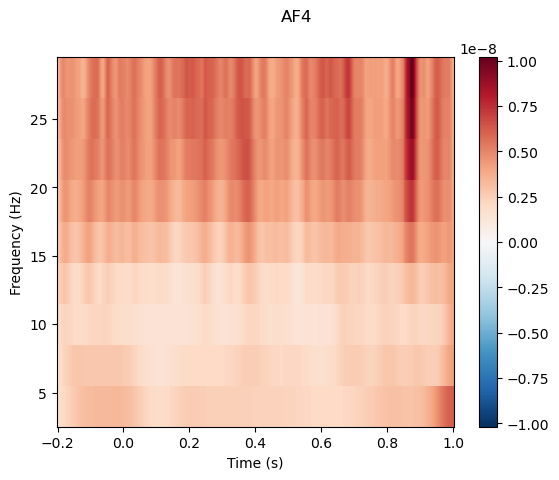

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


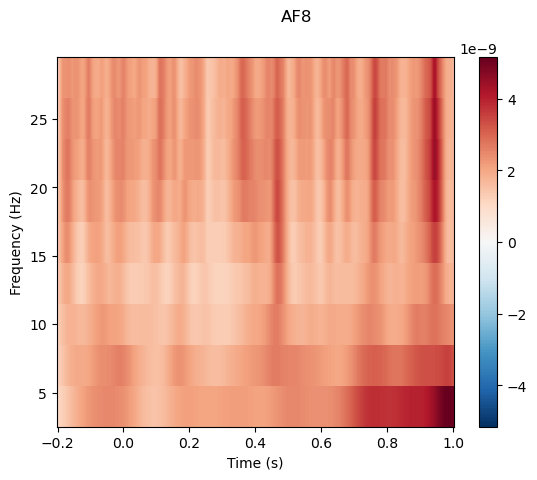

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


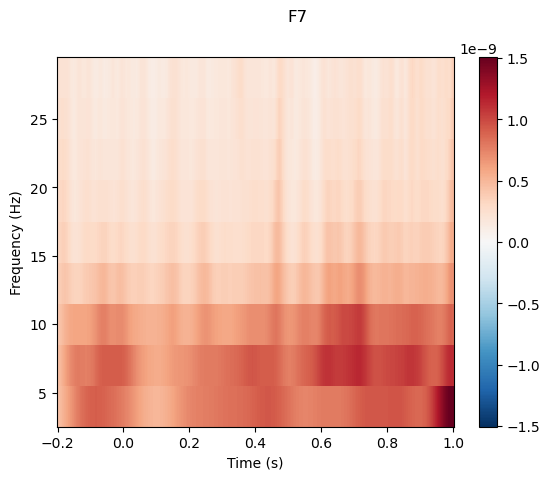

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


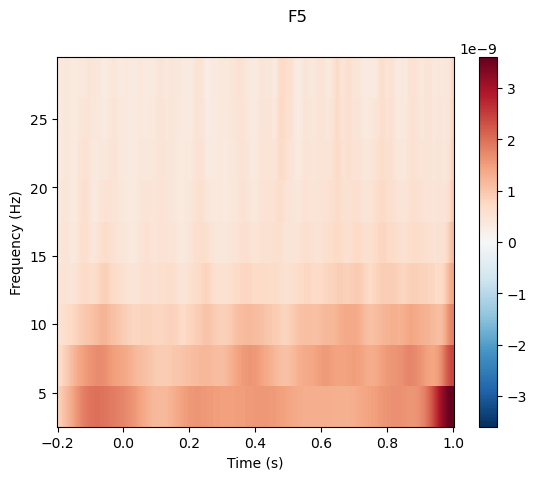

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


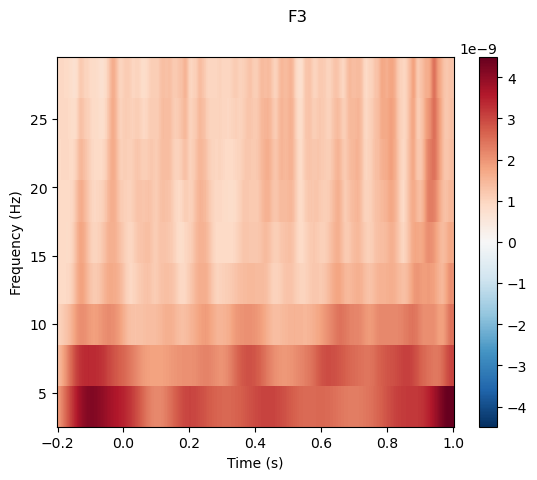

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


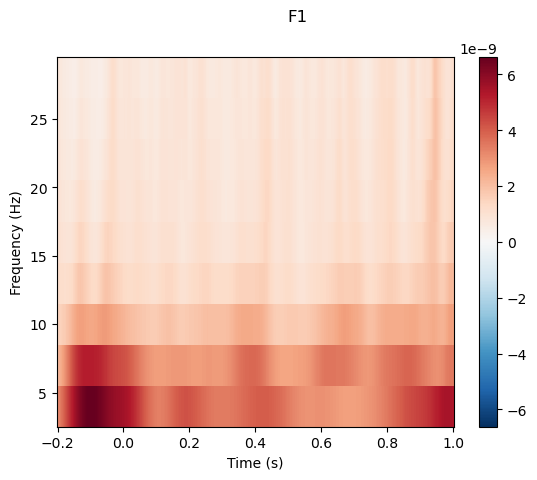

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


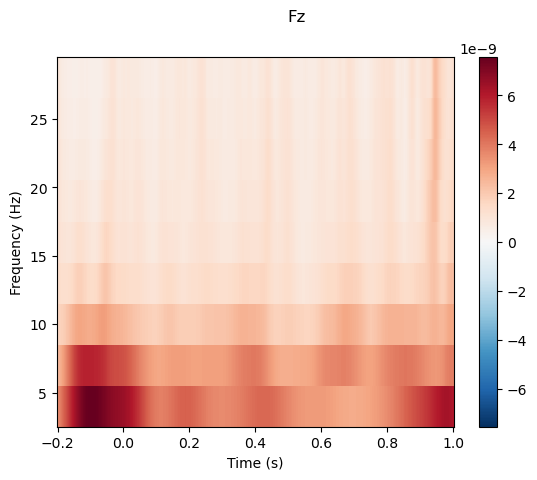

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


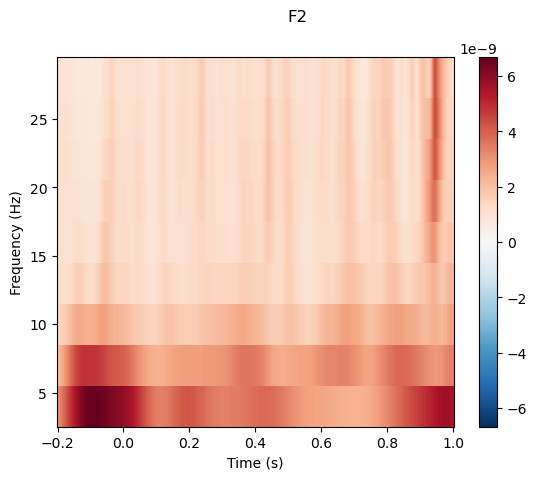

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


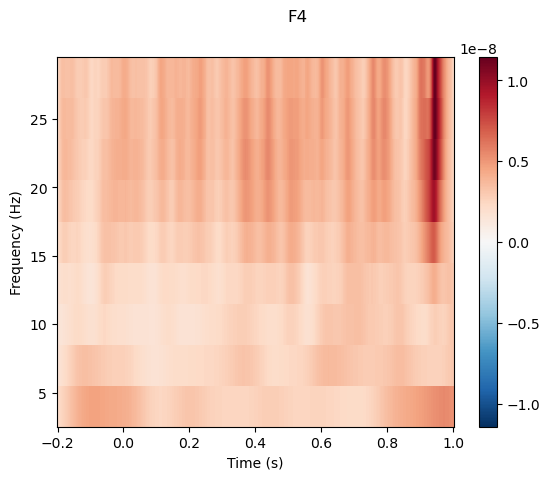

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


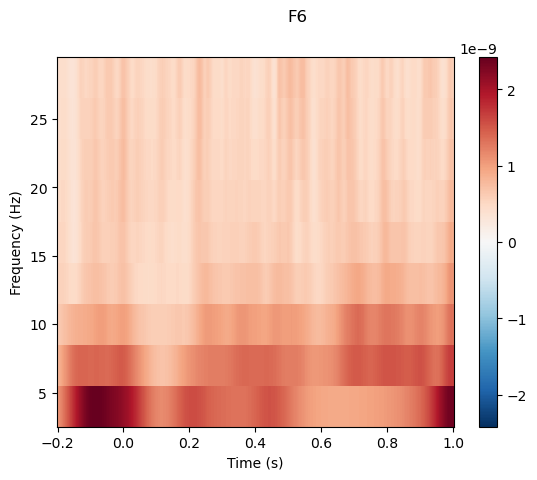

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


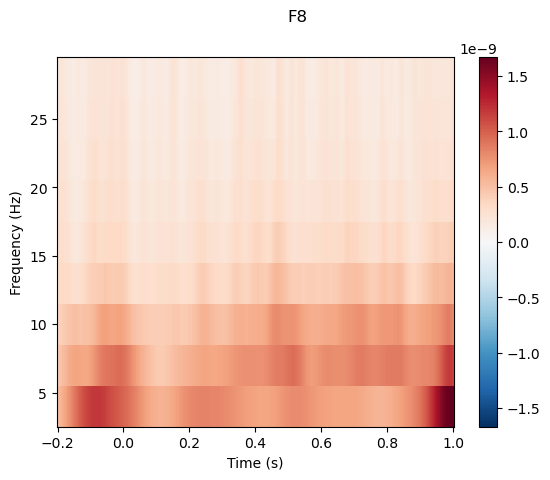

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


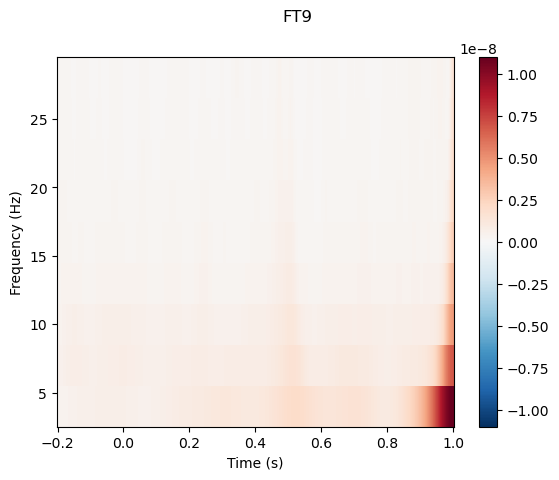

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


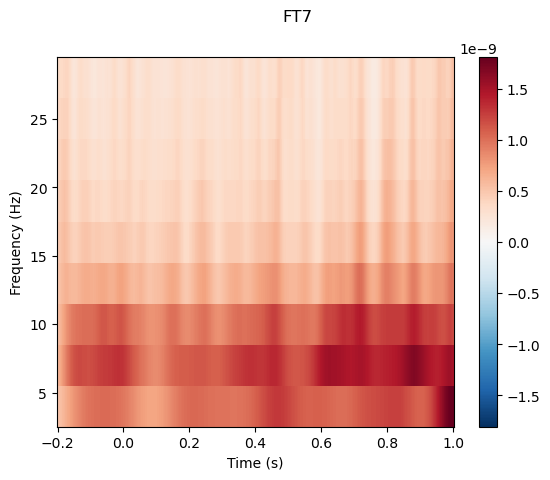

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


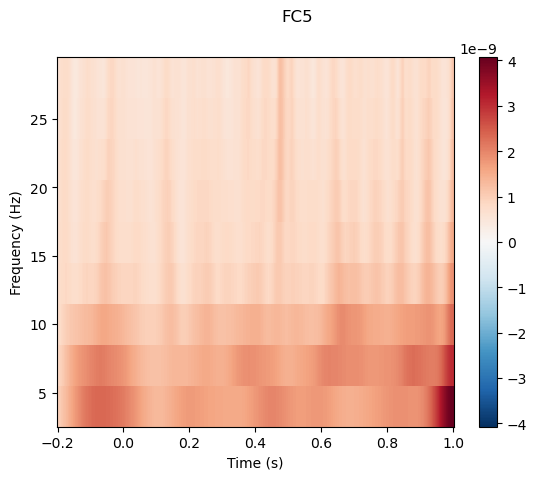

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


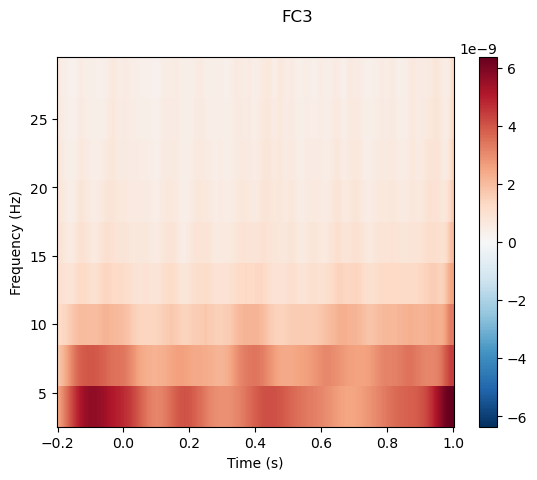

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


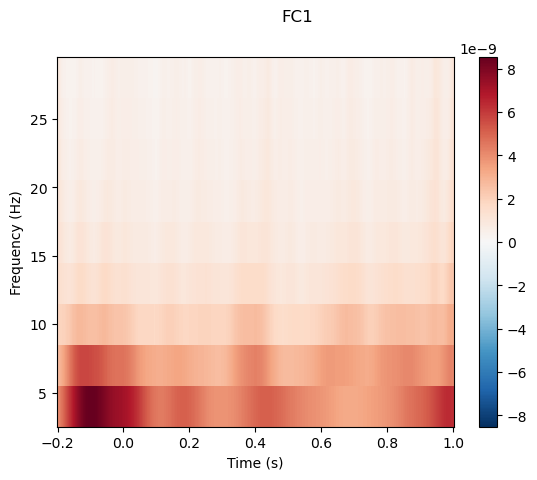

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


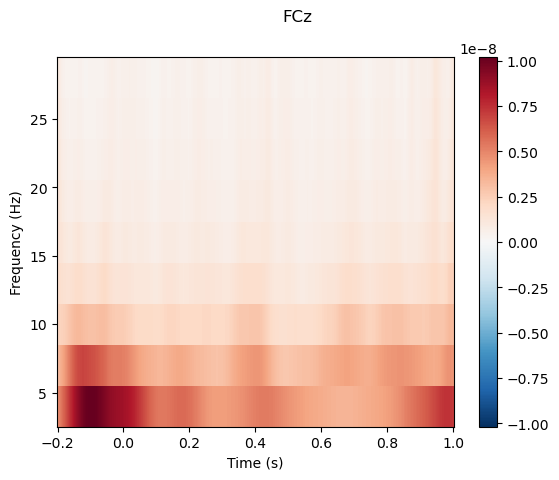

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


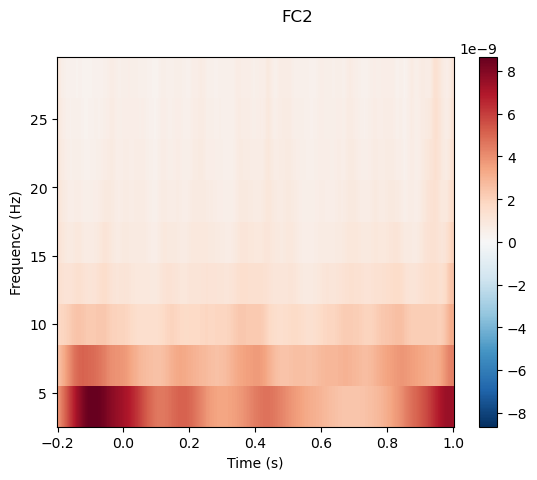

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


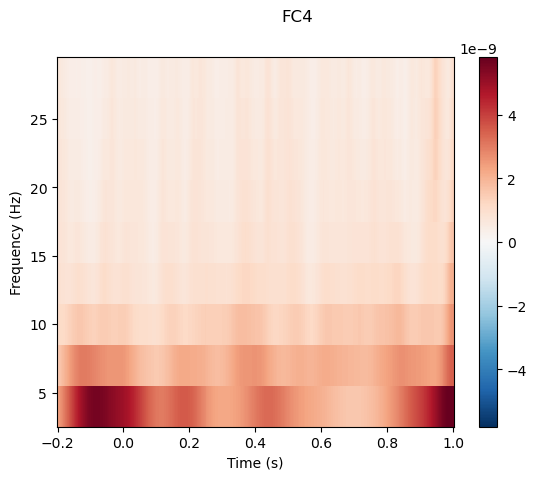

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


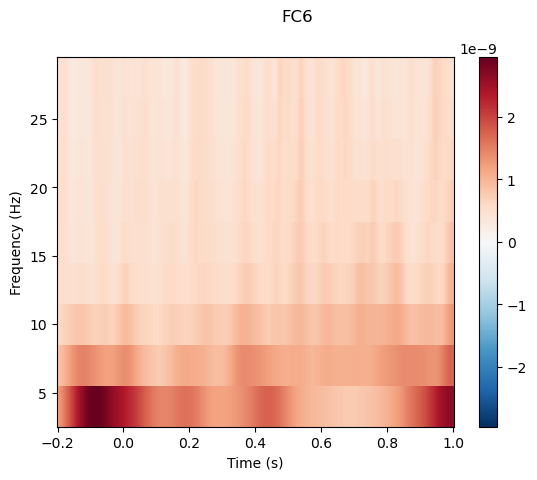

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


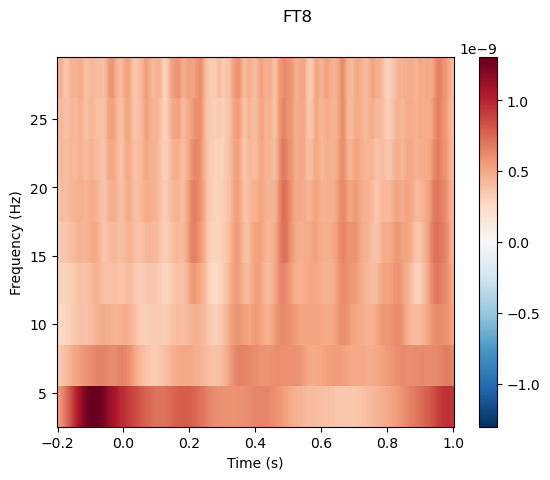

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


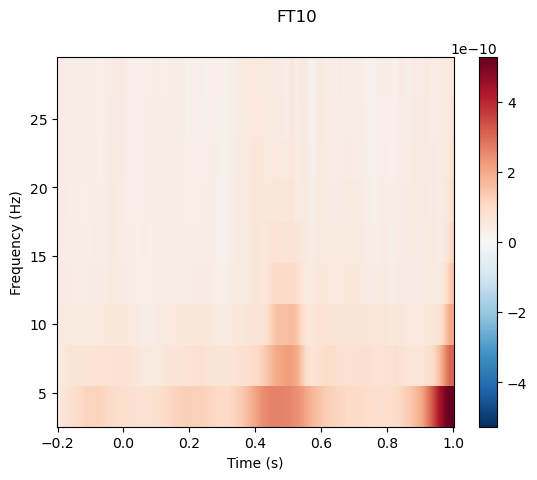

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


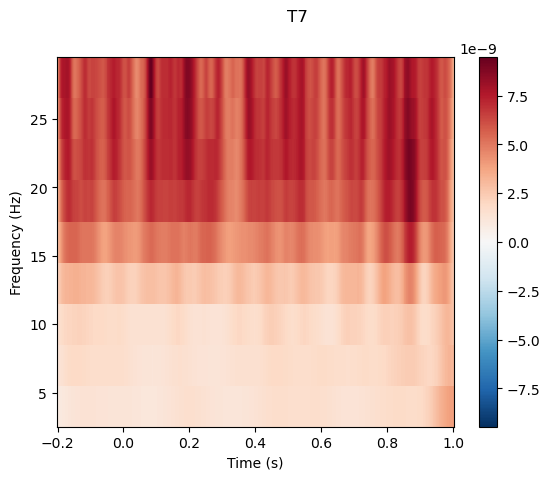

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


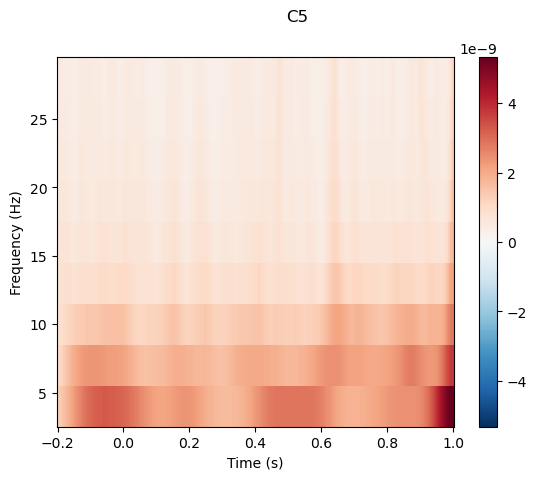

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


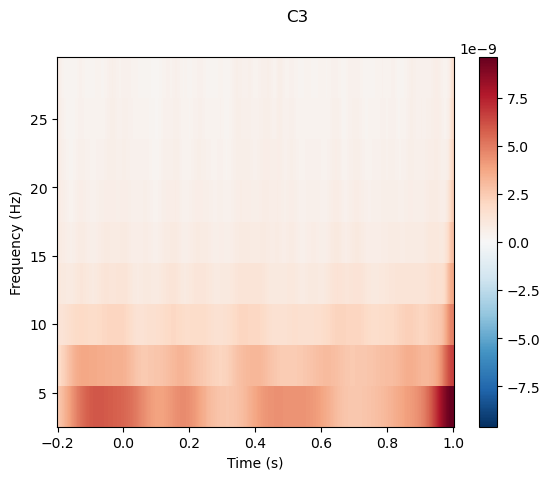

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


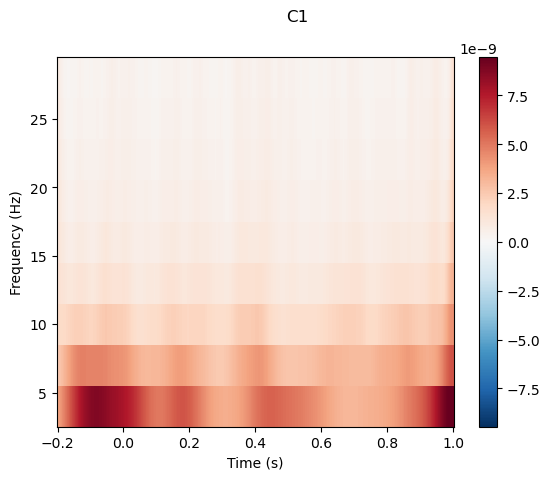

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


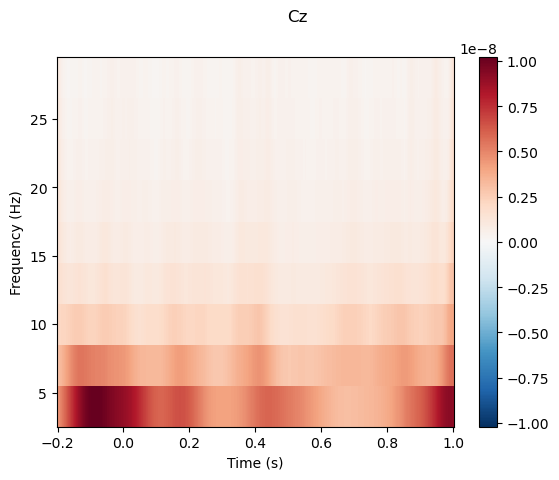

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


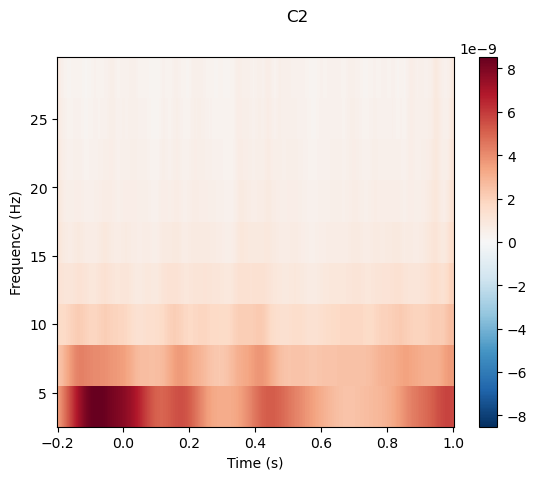

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


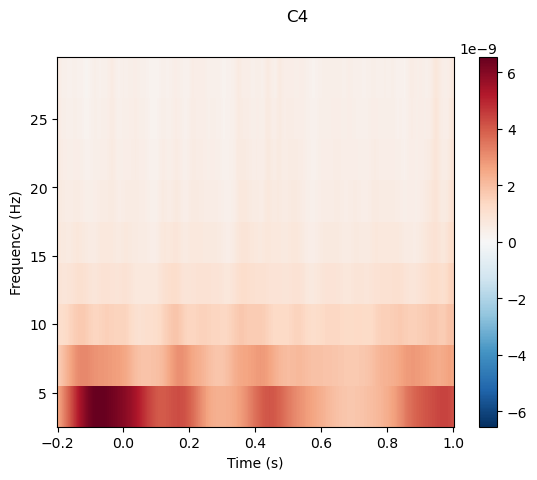

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


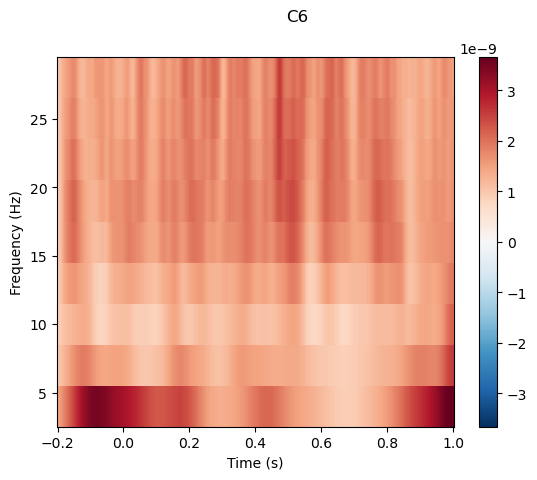

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


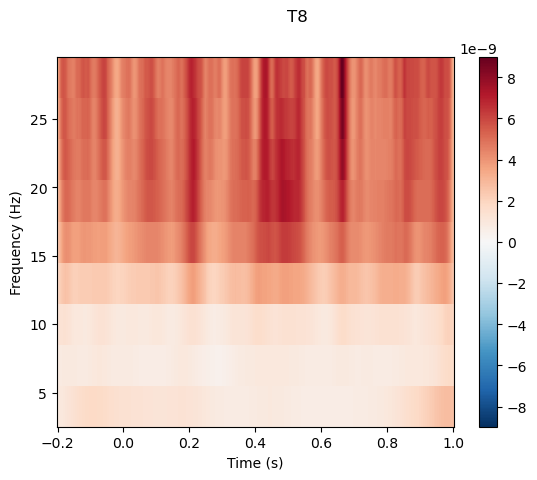

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


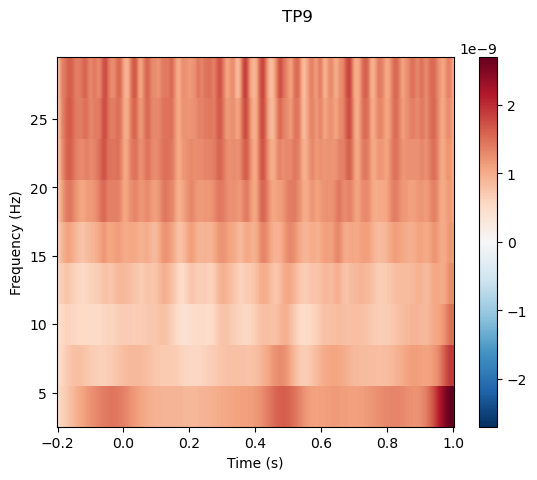

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


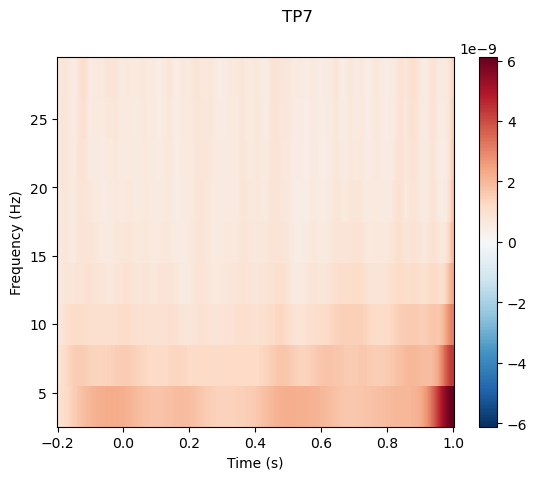

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


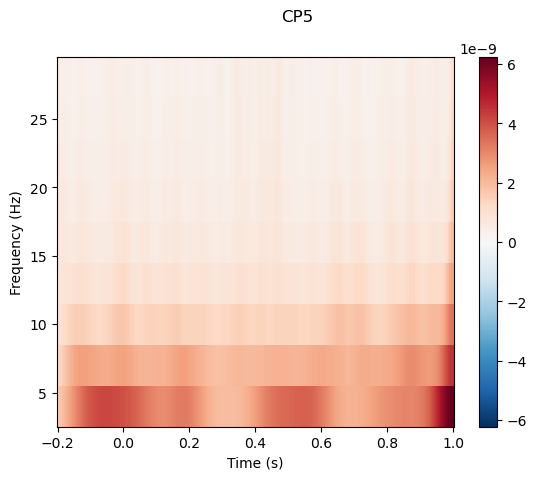

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


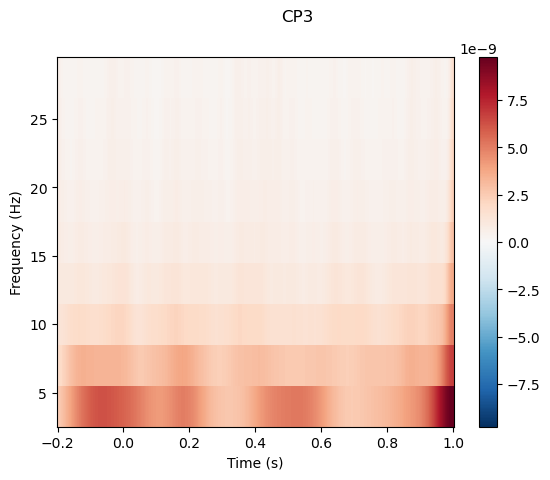

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


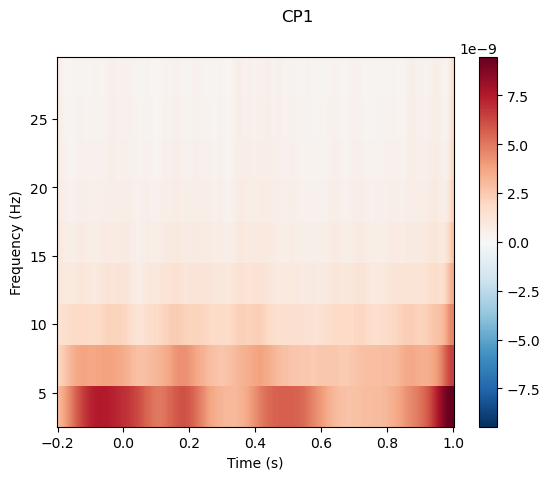

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


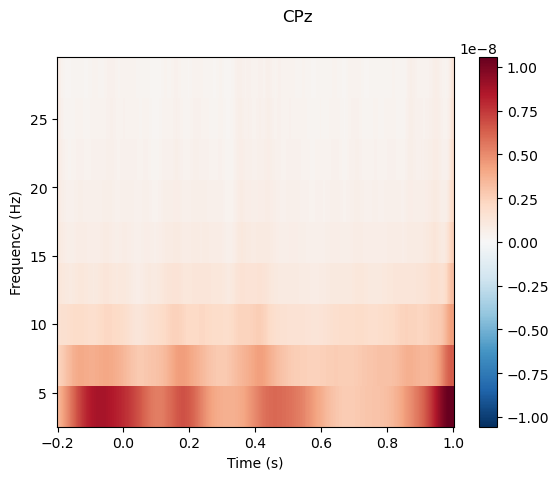

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


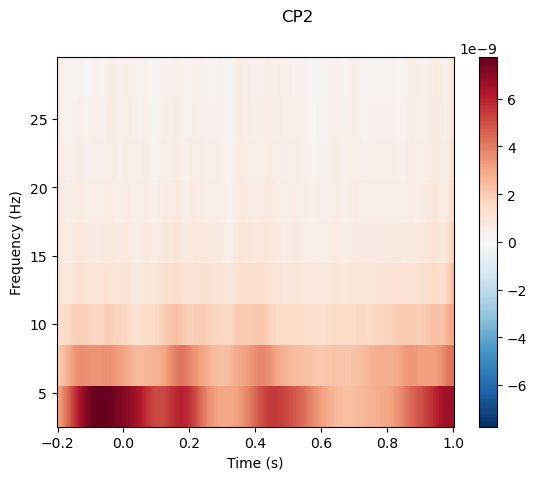

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


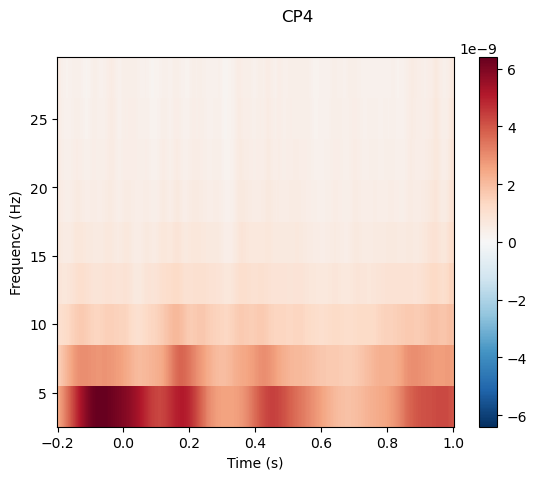

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


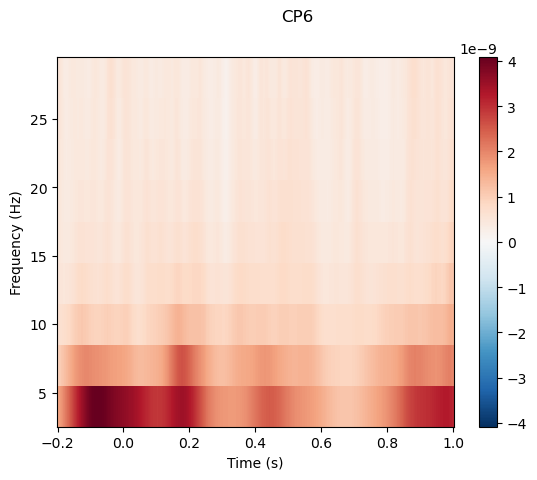

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


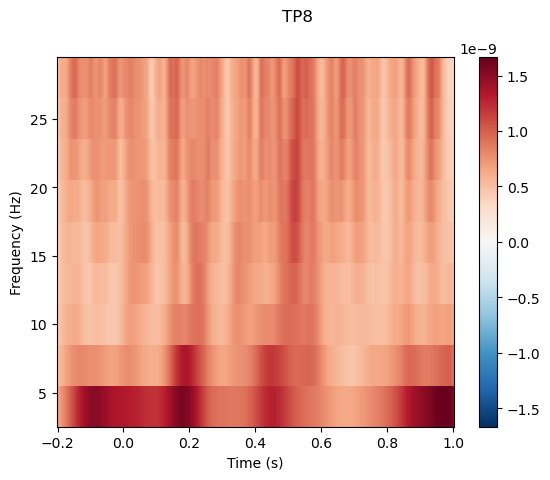

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


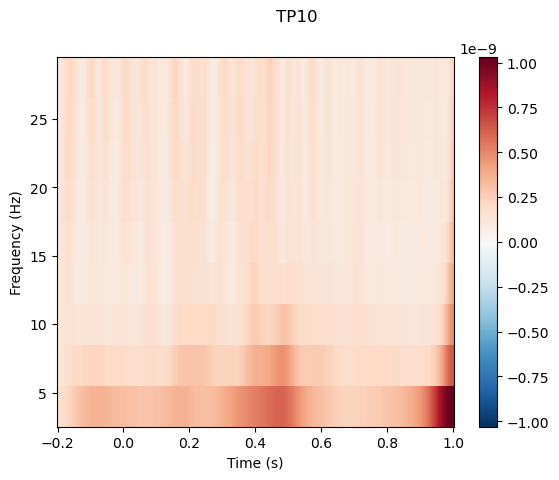

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


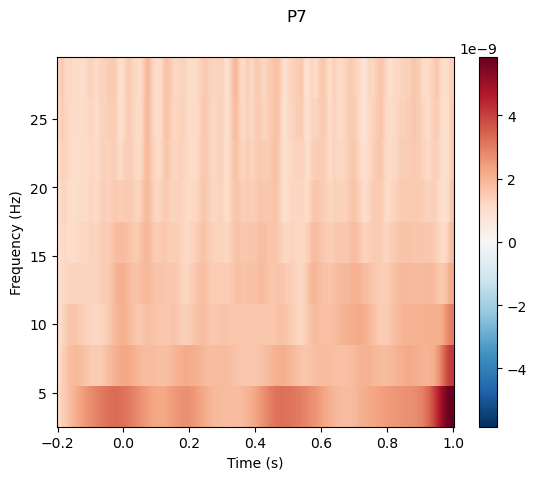

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


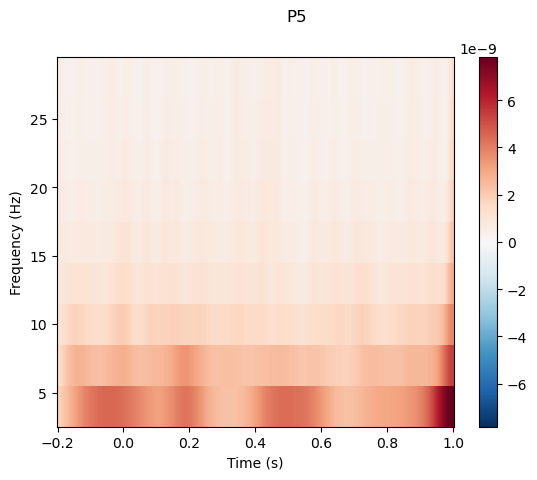

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


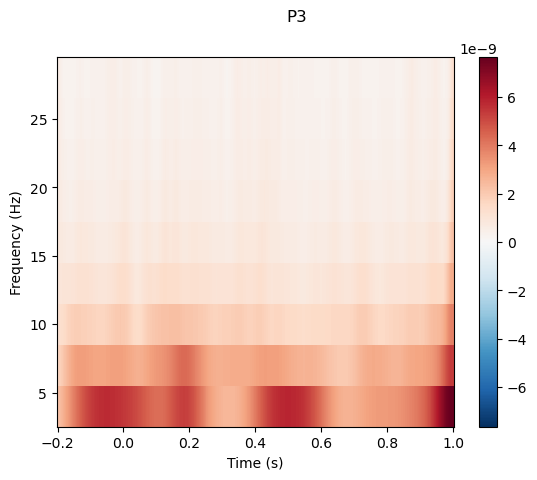

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


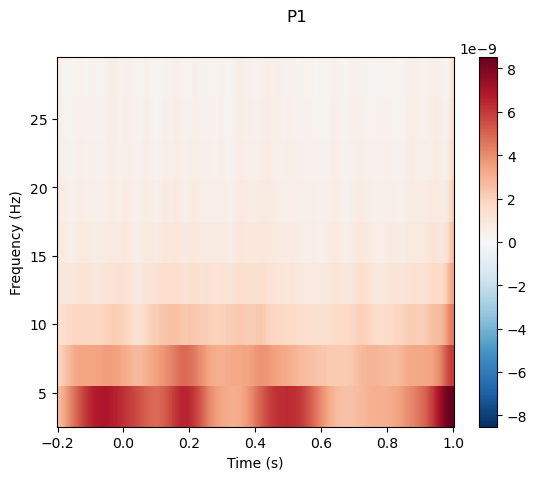

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


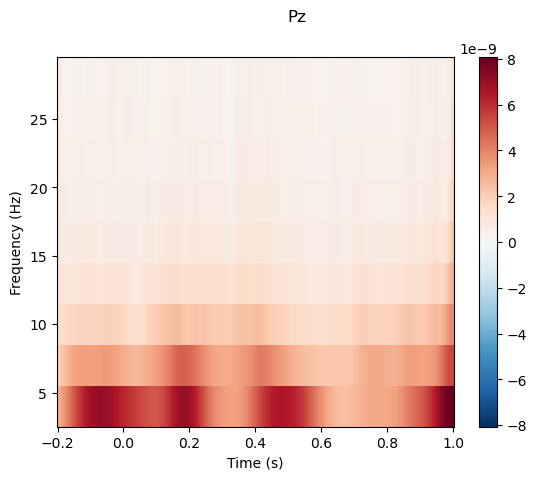

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


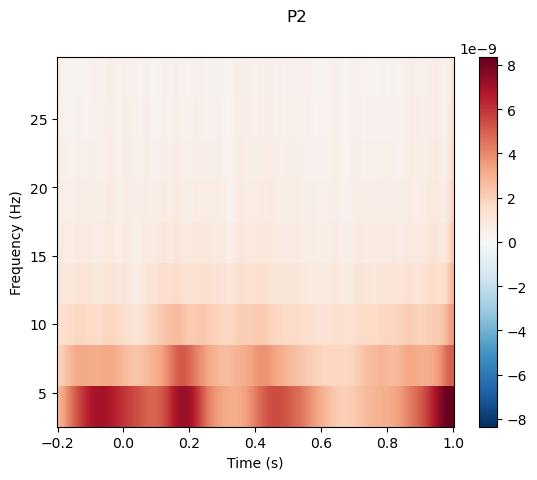

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


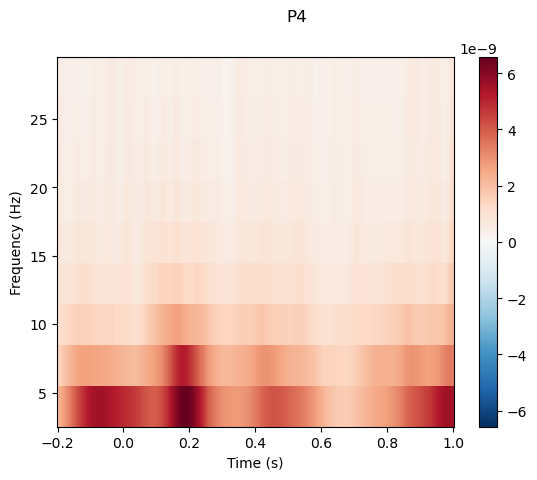

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


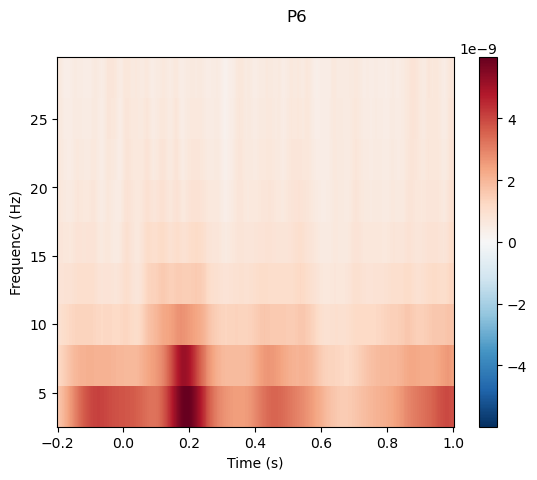

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


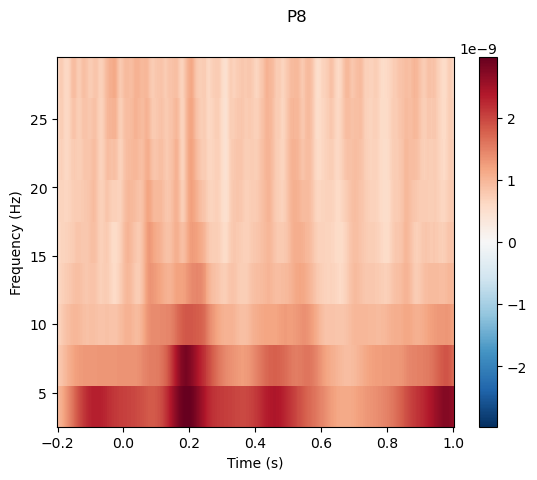

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


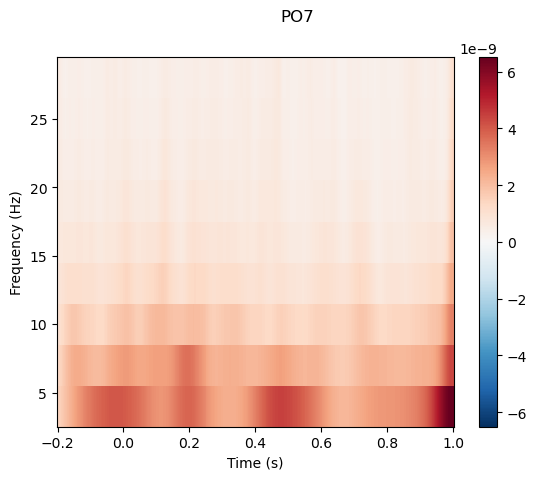

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


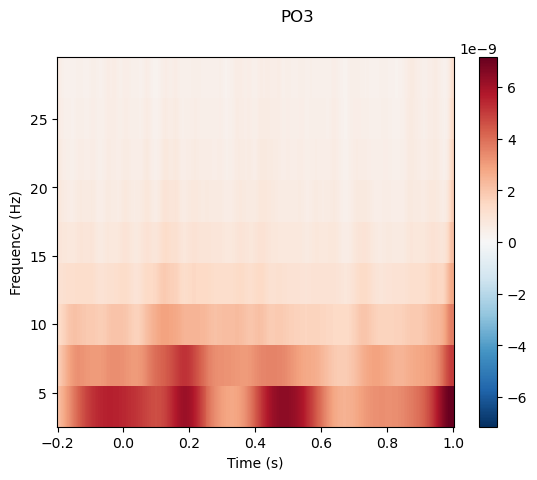

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


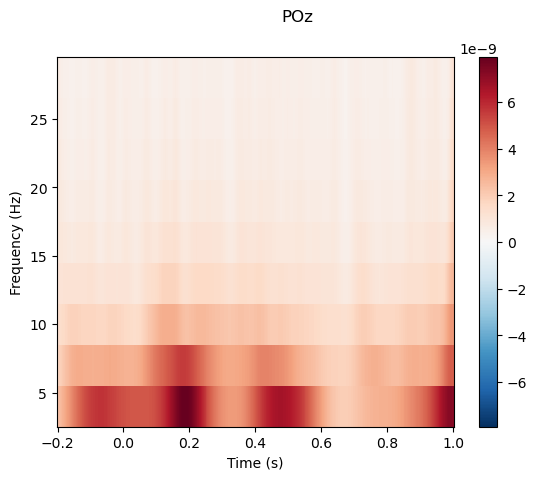

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


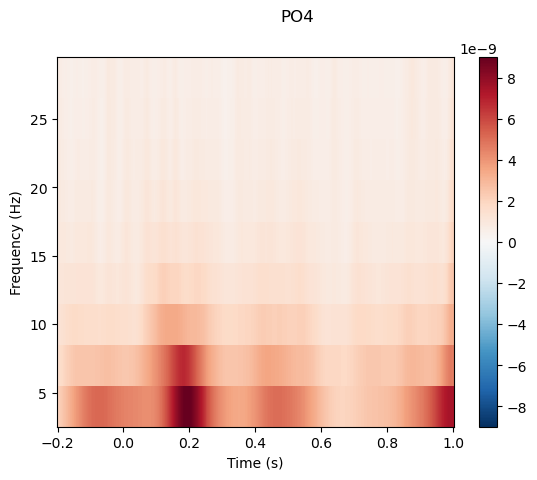

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


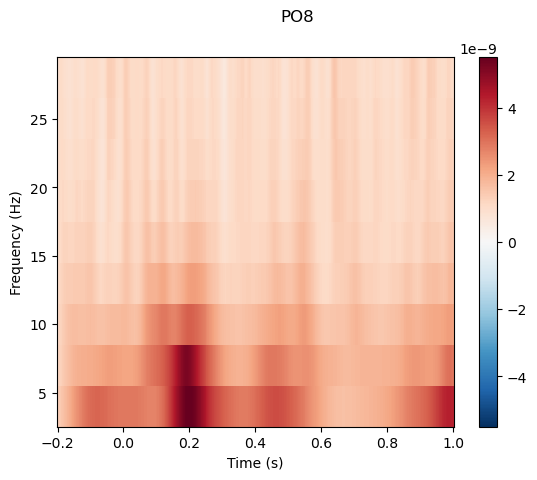

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


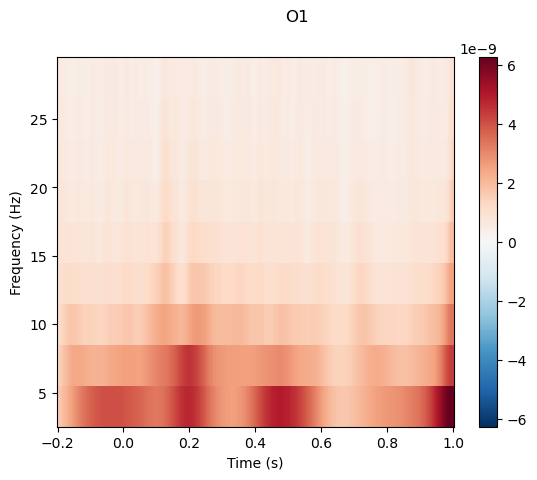

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


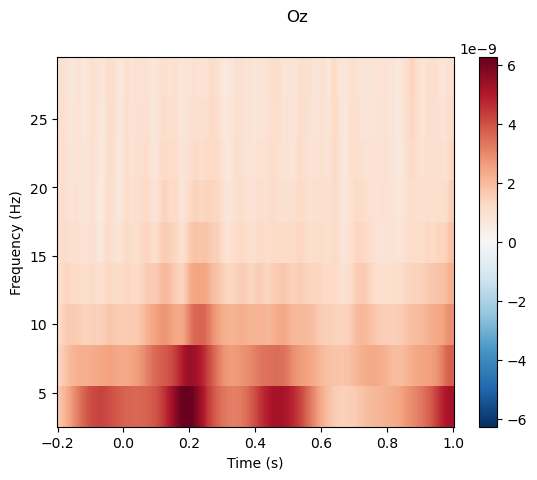

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


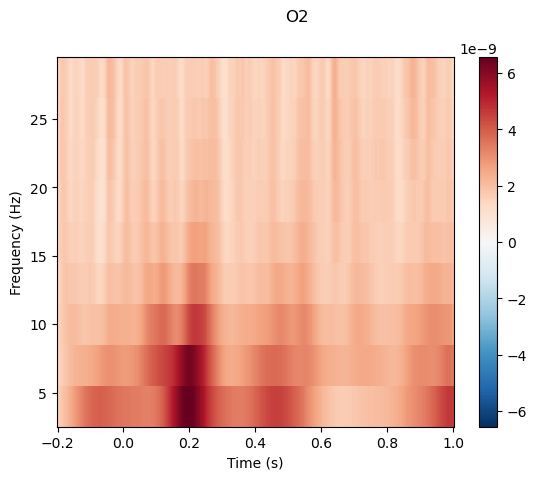

In [29]:
frequencies = np.arange(4, 30, 3)
power = mne.time_frequency.tfr_morlet(epochs, n_cycles=2, return_itc=False, freqs=frequencies, decim=3)
for i in range(len(channel)):
    ch = channel[i]
    power.plot(picks=ch, title=ch)

In [31]:
eeg_temp = reconst_raw.copy().pick_types(eeg=True, eog=False, ecg=False)
channel = eeg_temp.ch_names

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [32]:
iter_freqs = [("Theta", 4, 7), ("Alpha", 8, 12), ("Beta", 13, 25)]

In [33]:
frequency_map = list()

for band, fmin, fmax in iter_freqs:
    # (re)load the data to save memory
    eeg_temp.load_data()

    # epoch
    epochs = mne.Epochs(
        eeg_temp,
        events,
        tmin = -0.2,
        tmax = 1,
        baseline=None,
        preload=True,
    )
    # remove evoked response
    epochs.subtract_evoked()

    # get analytic signal (envelope)
    eeg_temp.apply_hilbert(envelope=True)
    frequency_map.append(((band, fmin, fmax), epochs.average()))
    del epochs
del raw

Not setting metadata
47 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 47 events and 1201 original time points ...
5 bad epochs dropped
Subtracting Evoked from Epochs
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
[done]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
47 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 47 events and 1201 original time points ...
5 bad epochs dropped
Subtracting Evoked from Epochs
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
[done]
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Not setting metadata
47 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 47 events and 1201 original time points ...
5 bad epoc

In [34]:
from mne.baseline import rescale
from mne.datasets import somato
from mne.stats import bootstrap_confidence_interval

In [35]:
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x**2, axis=0)

Applying baseline correction (mode: mean)


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


Text(0.5, 0, 'Time [ms]')

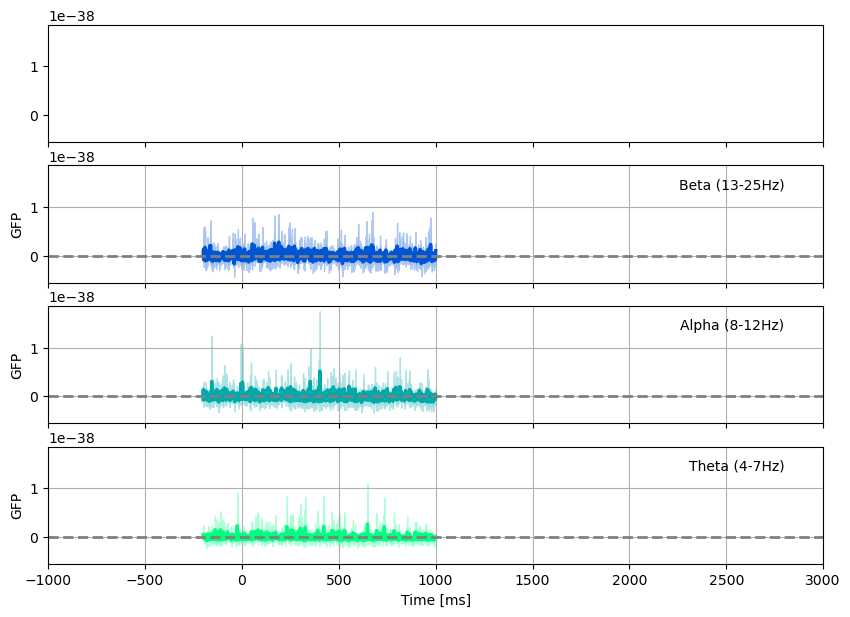

Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none


In [ ]:
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.colormaps["winter_r"](np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
    frequency_map, colors, axes.ravel()[::-1]
):
    times = average.times * 1e3
    gfp = np.sum(average.data**2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle="--", color="grey", linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(
        average.data, random_state=0, stat_fun=stat_fun
    )
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel("GFP")
    ax.annotate(
        "%s (%d-%dHz)" % (freq_name, fmin, fmax),
        xy=(0.95, 0.8),
        horizontalalignment="right",
        xycoords="axes fraction",
    )
    ax.set_xlim(-1000, 3000)

axes.ravel()[-1].set_xlabel("Time [ms]")